# Introduction

Our project focuses on predicting strokes within humans. The dataset is extensive, containing over 5100 examples and including features such as gender, age, hypertenstion, heart disease, marriage, job occupation, residence type, glucose levels, bmi, and smoking status. These features will be used to make a binary prediction of whether that person has had a stroke or not. This is very interesting as our analysis describes what factors contribute most and least to strokes. This information can be informative regarding medical and health practices.

# Setup

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

import torch

In [99]:
# Initialize DataFrame
df = pd.read_csv('healthcare-dataset-stroke-data.csv').drop('id', axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Initial Analysis

In [100]:
# Dataset Overview
print("Dataset Shape:", df.shape)

print("\nColumn Data Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())
print(f"\nMissing BMI: {df['bmi'].isnull().sum()} ({df['bmi'].isnull().sum()/len(df)*100:.2f}%)")

Dataset Shape: (5110, 11)

Column Data Types:
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Basic Statistics:
               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.0

Stroke Distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Stroke Percentage:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


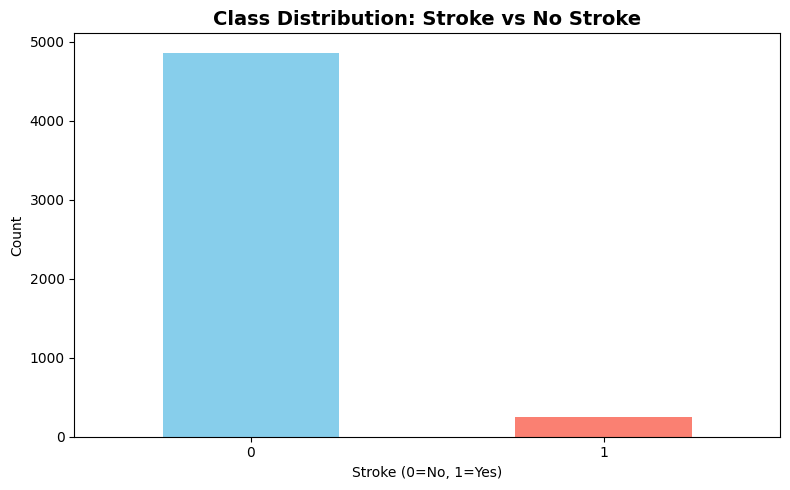

In [101]:
# Check class balance (Target variable)
print("Stroke Distribution:")
print(df['stroke'].value_counts())
print("\nStroke Percentage:")
print(df['stroke'].value_counts(normalize=True) * 100)

# Visualize class balance
plt.figure(figsize=(8, 5))
df['stroke'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Stroke vs No Stroke', fontsize=14, fontweight='bold')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

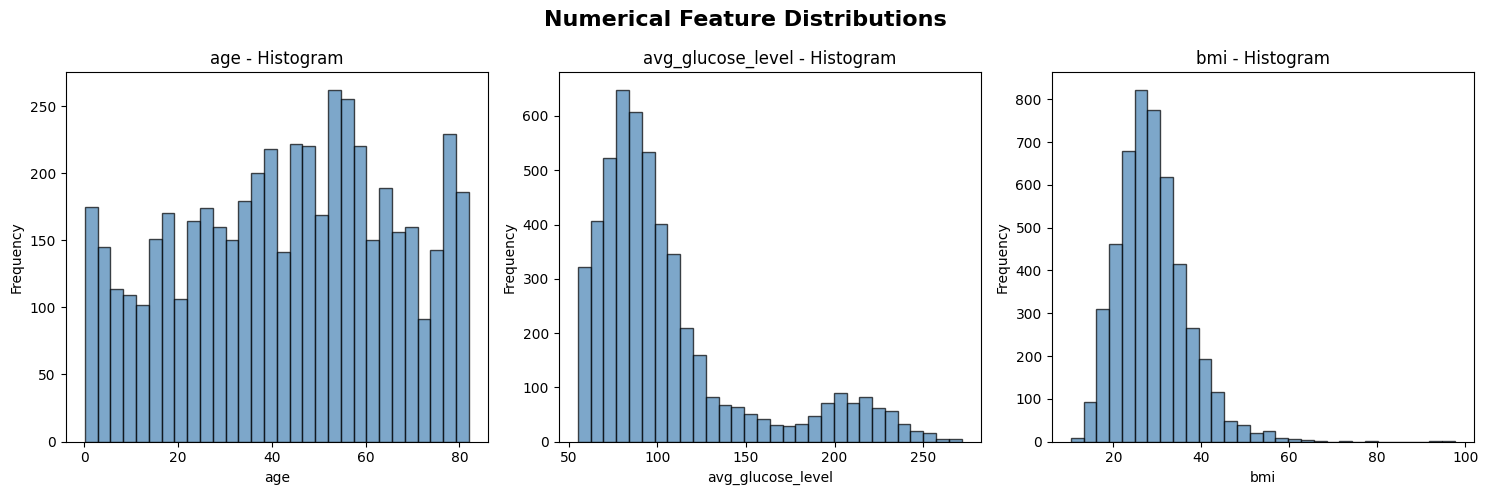

In [102]:
# Numerical Feature Distributions
numerical_features = ['age', 'avg_glucose_level', 'bmi']
num_features = len(numerical_features)
fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5))
fig.suptitle('Numerical Feature Distributions', fontsize=16, fontweight='bold')

if num_features == 1:
    axes = [axes] 

for idx, feature in enumerate(numerical_features):
    axes[idx].hist(df[feature].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature} - Histogram')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



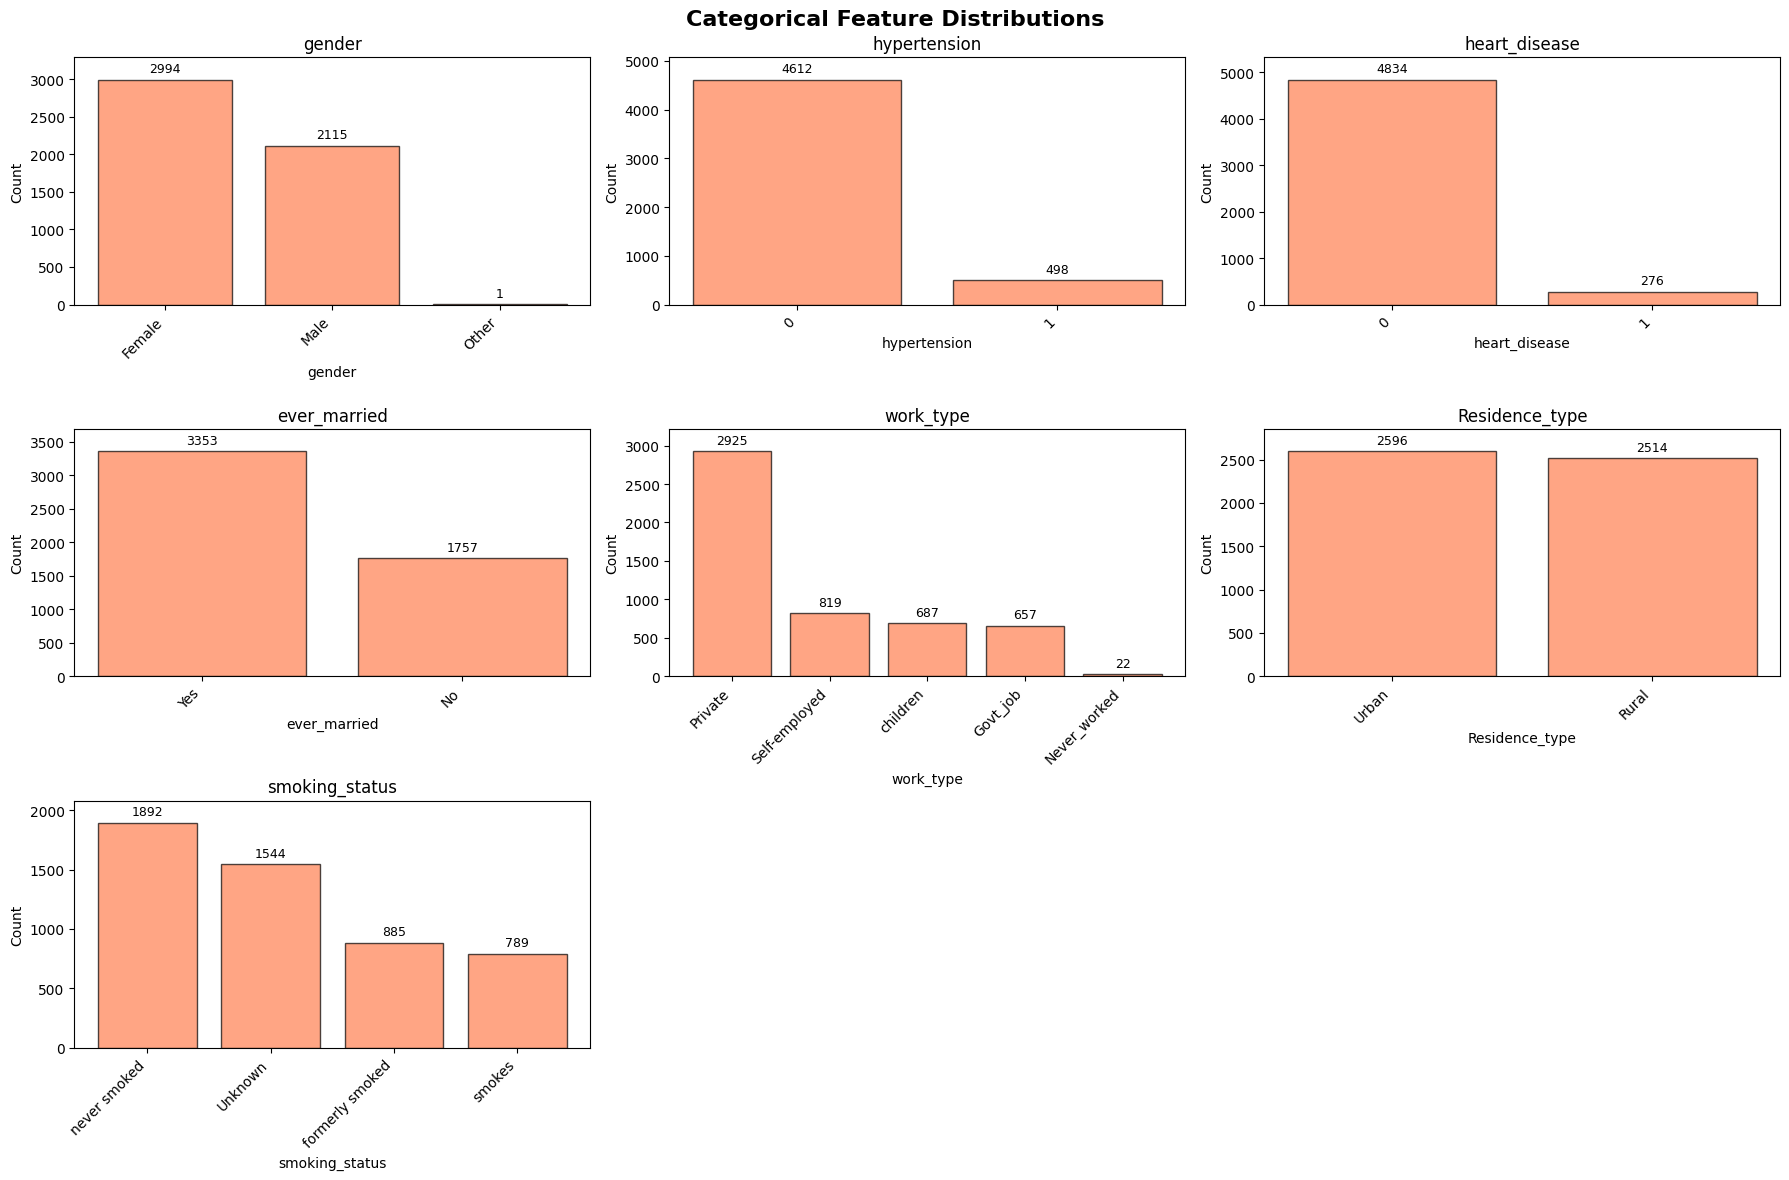

In [103]:
# Categorical Feature Distributions
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Categorical Feature Distributions', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    counts = df[feature].value_counts()
    axes[idx].bar(range(len(counts)), counts.values, color='coral', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(range(len(counts)))
    axes[idx].set_xticklabels(counts.index, rotation=45, ha='right')
    
    # Add value labels on bars
    max_val = max(counts.values)
    for i, v in enumerate(counts.values):
        axes[idx].text(i, v + max_val * 0.02, str(v), ha='center', va='bottom', fontsize=9)
    
    # Add some padding to y-axis
    axes[idx].set_ylim(0, max_val * 1.1)

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


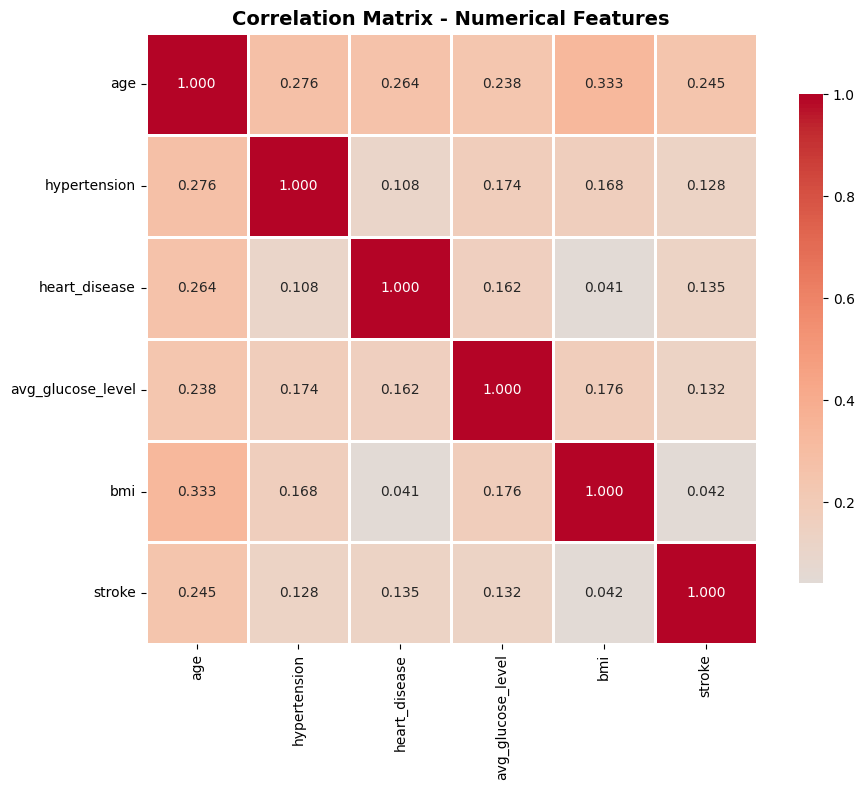


Correlations with Stroke (Target):
stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64


In [104]:
# Correlation Matrix for Numerical Features
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelations with Stroke (Target):")
print(correlation_matrix['stroke'].sort_values(ascending=False))


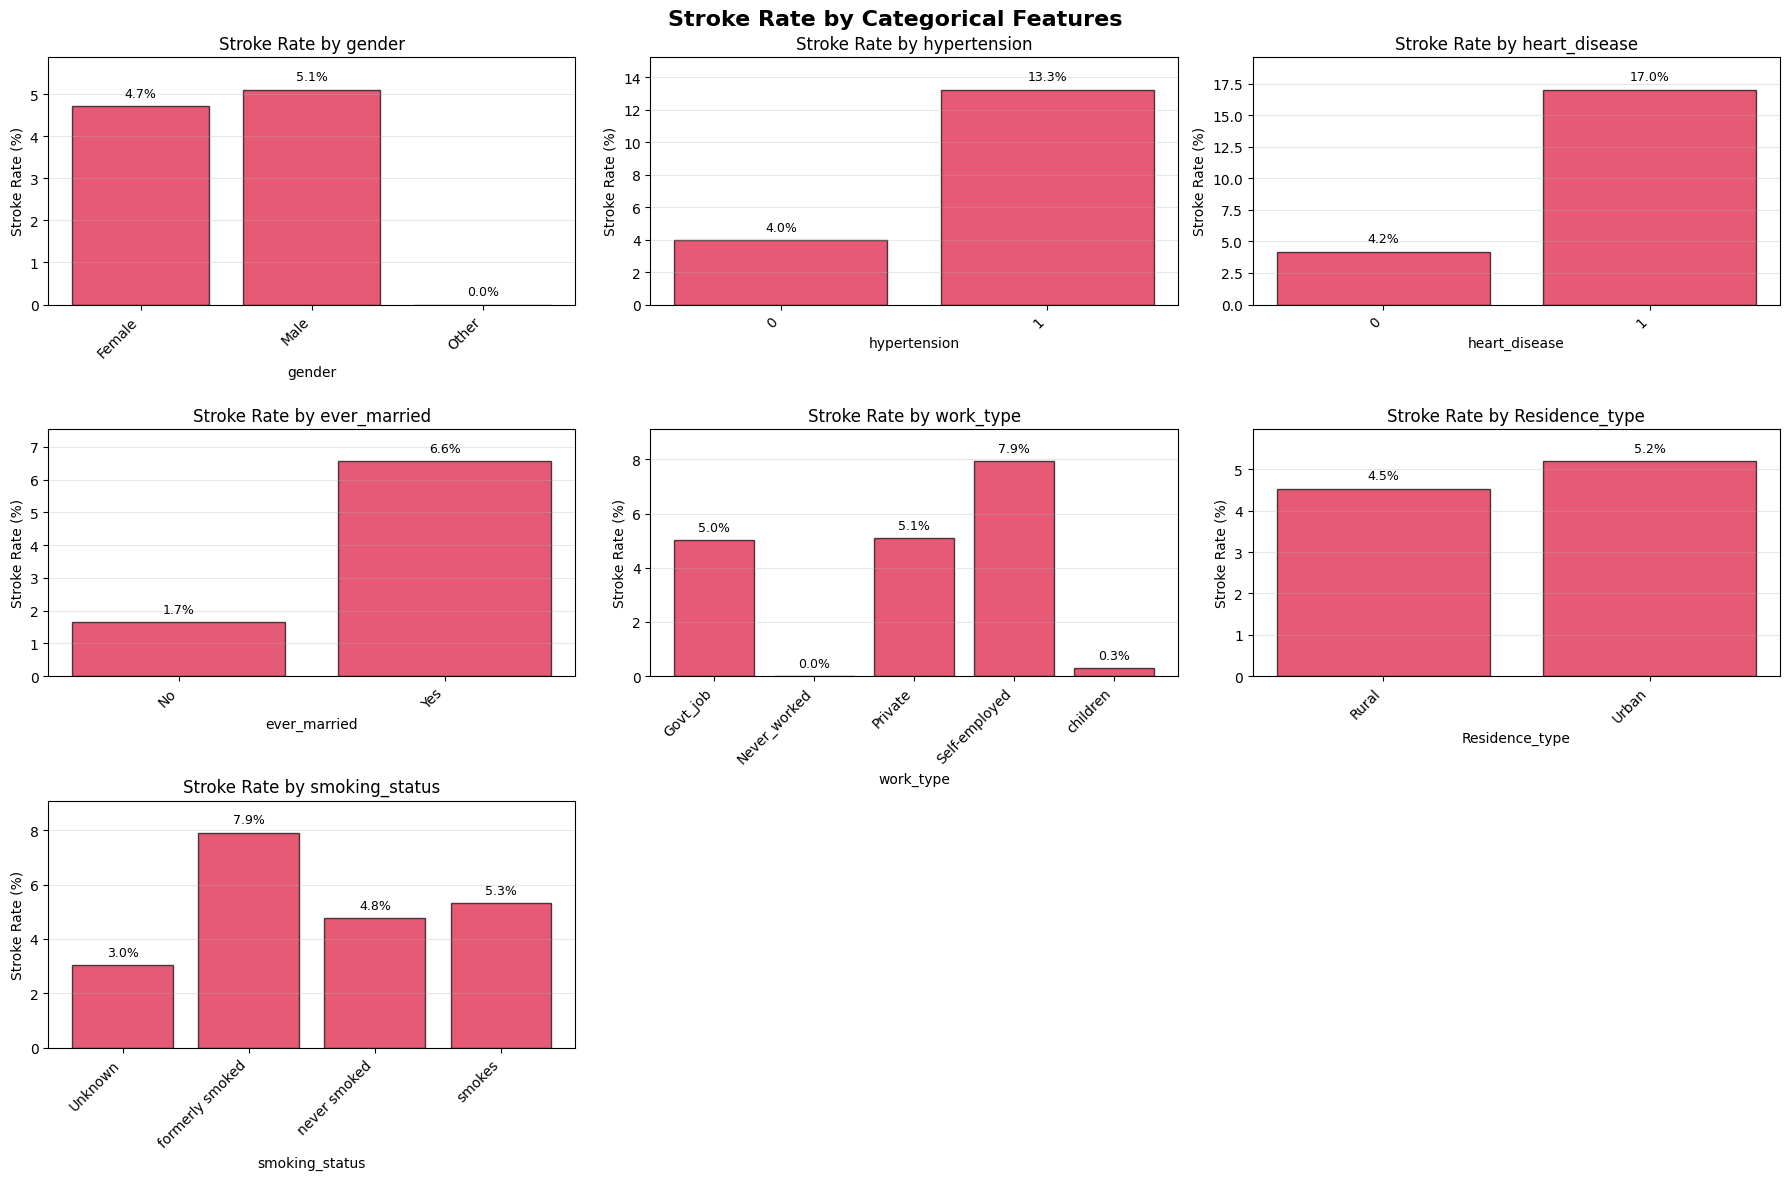

In [105]:
# Categorical Features vs Stroke 
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Stroke Rate by Categorical Features', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    # Calculate stroke rate for each category
    stroke_rate = df.groupby(feature)['stroke'].agg(['sum', 'count', 'mean'])
    stroke_rate['percentage'] = stroke_rate['mean'] * 100
    
    # Create grouped bar chart
    x = range(len(stroke_rate))
    axes[idx].bar(x, stroke_rate['percentage'], color='crimson', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Stroke Rate by {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Stroke Rate (%)')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(stroke_rate.index, rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    max_pct = stroke_rate['percentage'].max()
    for i, v in enumerate(stroke_rate['percentage']):
        axes[idx].text(i, v + max_pct * 0.03, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Add some padding to y-axis
    axes[idx].set_ylim(0, max_pct * 1.15)

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [106]:
# Key Observations from Initial EDA
print("KEY OBSERVATIONS FROM INITIAL ANALYSIS")

print("\n1. CLASS IMBALANCE:")
print(f"   - No Stroke: {(df['stroke']==0).sum()} ({(df['stroke']==0).sum()/len(df)*100:.1f}%)")
print(f"   - Stroke: {(df['stroke']==1).sum()} ({(df['stroke']==1).sum()/len(df)*100:.1f}%)")
print("   Highly imbalanced dataset")

print("\n2. MISSING DATA:")
print(f"   - BMI has {(df['bmi'].isna().sum()/len(df)*100):.2f}% missing values (before imputation)")
print("   - All other features are complete")

print("\n3. STRONGEST CORRELATIONS WITH STROKE:")
corr_with_stroke = correlation_matrix['stroke'].drop('stroke').sort_values(ascending=False)
for feature, corr_value in corr_with_stroke.head(3).items():
    print(f"   - {feature}: {corr_value:.3f}")

print("\n4. NUMERICAL FEATURE DISTRIBUTIONS:")
print("   - Age: Right-skewed, most patients between 40-80")
print("   - Glucose: Right-skewed with some high outliers")
print("   - BMI: Approximately normal distribution")

print("\n5. CATEGORICAL FEATURE DISTRIBUTIONS:")
print(f"   - Gender: {df['gender'].value_counts()['Female']} Female ({df['gender'].value_counts()['Female']/len(df)*100:.1f}%), " +
      f"{df['gender'].value_counts()['Male']} Male ({df['gender'].value_counts()['Male']/len(df)*100:.1f}%)")
print(f"   - Hypertension: {(df['hypertension']==1).sum()} patients ({(df['hypertension']==1).sum()/len(df)*100:.1f}%) have hypertension")
print(f"   - Heart Disease: {(df['heart_disease']==1).sum()} patients ({(df['heart_disease']==1).sum()/len(df)*100:.1f}%) have heart disease")
print(f"   - Marriage: {(df['ever_married']=='Yes').sum()} patients ({(df['ever_married']=='Yes').sum()/len(df)*100:.1f}%) are married")
print(f"   - Work Type: Private sector dominates ({df['work_type'].value_counts()['Private']} patients, {df['work_type'].value_counts()['Private']/len(df)*100:.1f}%)")
print(f"   - Residence: {(df['Residence_type']=='Urban').sum()} Urban ({(df['Residence_type']=='Urban').sum()/len(df)*100:.1f}%), " +
      f"{(df['Residence_type']=='Rural').sum()} Rural ({(df['Residence_type']=='Rural').sum()/len(df)*100:.1f}%)")
smoking_counts = df['smoking_status'].value_counts()
print(f"   - Smoking Status: {smoking_counts['never smoked']} never smoked ({smoking_counts['never smoked']/len(df)*100:.1f}%), " +
      f"{smoking_counts['formerly smoked']} formerly smoked ({smoking_counts['formerly smoked']/len(df)*100:.1f}%), " +
      f"{smoking_counts['smokes']} smokes ({smoking_counts['smokes']/len(df)*100:.1f}%), " +
      f"{smoking_counts['Unknown']} unknown ({smoking_counts['Unknown']/len(df)*100:.1f}%)")

print("\n6. STROKE RISK BY CATEGORY (Key Risk Factors):")
hyp_stroke_rate = df[df['hypertension']==1]['stroke'].mean() * 100
no_hyp_stroke_rate = df[df['hypertension']==0]['stroke'].mean() * 100
heart_stroke_rate = df[df['heart_disease']==1]['stroke'].mean() * 100
no_heart_stroke_rate = df[df['heart_disease']==0]['stroke'].mean() * 100
married_stroke_rate = df[df['ever_married']=='Yes']['stroke'].mean() * 100
not_married_stroke_rate = df[df['ever_married']=='No']['stroke'].mean() * 100

print(f"   - Hypertension: {hyp_stroke_rate:.1f}% stroke rate (vs {no_hyp_stroke_rate:.1f}% without)")
print(f"   - Heart Disease: {heart_stroke_rate:.1f}% stroke rate (vs {no_heart_stroke_rate:.1f}% without)")
print(f"   - Ever Married: {married_stroke_rate:.1f}% stroke rate (vs {not_married_stroke_rate:.1f}% not married)")
print(f"   - Gender: Similar rates between Male ({df[df['gender']=='Male']['stroke'].mean()*100:.1f}%) " +
      f"and Female ({df[df['gender']=='Female']['stroke'].mean()*100:.1f}%)")
print(f"   - Smoking: formerly smoked ({df[df['smoking_status']=='formerly smoked']['stroke'].mean()*100:.1f}%), " +
      f"never smoked ({df[df['smoking_status']=='never smoked']['stroke'].mean()*100:.1f}%), " +
      f"smokes ({df[df['smoking_status']=='smokes']['stroke'].mean()*100:.1f}%), " +
      f"unknown ({df[df['smoking_status']=='Unknown']['stroke'].mean()*100:.1f}%)")

KEY OBSERVATIONS FROM INITIAL ANALYSIS

1. CLASS IMBALANCE:
   - No Stroke: 4861 (95.1%)
   - Stroke: 249 (4.9%)
   Highly imbalanced dataset

2. MISSING DATA:
   - BMI has 3.93% missing values (before imputation)
   - All other features are complete

3. STRONGEST CORRELATIONS WITH STROKE:
   - age: 0.245
   - heart_disease: 0.135
   - avg_glucose_level: 0.132

4. NUMERICAL FEATURE DISTRIBUTIONS:
   - Age: Right-skewed, most patients between 40-80
   - Glucose: Right-skewed with some high outliers
   - BMI: Approximately normal distribution

5. CATEGORICAL FEATURE DISTRIBUTIONS:
   - Gender: 2994 Female (58.6%), 2115 Male (41.4%)
   - Hypertension: 498 patients (9.7%) have hypertension
   - Heart Disease: 276 patients (5.4%) have heart disease
   - Marriage: 3353 patients (65.6%) are married
   - Work Type: Private sector dominates (2925 patients, 57.2%)
   - Residence: 2596 Urban (50.8%), 2514 Rural (49.2%)
   - Smoking Status: 1892 never smoked (37.0%), 885 formerly smoked (17.3%), 7

# Preprocessing

### Imputing Null Values

In [107]:
# KNN Imputation for null bmi values
imputer = KNNImputer(n_neighbors=5)
df[['bmi']] = imputer.fit_transform(df[['bmi']])

# Verify
null_percentage = df.isnull().mean() * 100
print(null_percentage)

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64


### Encoding Categorical Data

In [108]:
df['ever_married'] = (df['ever_married'] == 'Yes').astype(int)
df['Residence_type'] = (df['Residence_type'] == 'Urban').astype(int)

df_encoded = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], drop_first=True, dtype=int)

# Verify
df_encoded.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1,228.69,36.600000,1,1,0,0,1,0,0,1,0,0
1,61.0,0,0,1,0,202.21,28.893237,1,0,0,0,0,1,0,0,1,0
2,80.0,0,1,1,0,105.92,32.500000,1,1,0,0,1,0,0,0,1,0
3,49.0,0,0,1,1,171.23,34.400000,1,0,0,0,1,0,0,0,0,1
4,79.0,1,0,1,0,174.12,24.000000,1,0,0,0,0,1,0,0,1,0
5,81.0,0,0,1,1,186.21,29.000000,1,1,0,0,1,0,0,1,0,0
6,74.0,1,1,1,0,70.09,27.400000,1,1,0,0,1,0,0,0,1,0
7,69.0,0,0,0,1,94.39,22.800000,1,0,0,0,1,0,0,0,1,0
8,59.0,0,0,1,0,76.15,28.893237,1,0,0,0,1,0,0,0,0,0
9,78.0,0,0,1,1,58.57,24.200000,1,0,0,0,1,0,0,0,0,0


### Train-Validation-Test Split

In [109]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} ({y_train.mean()*100:.2f}% stroke)")
print(f"Val: {X_val.shape[0]} ({y_val.mean()*100:.2f}% stroke)")
print(f"Test: {X_test.shape[0]} ({y_test.mean()*100:.2f}% stroke)")

Train: 3066 (4.86% stroke)
Val: 1022 (4.89% stroke)
Test: 1022 (4.89% stroke)


### Standard Scaling


In [110]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Verify
X_train_scaled.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1990,-1.827461,0,0,0,1,0.134857,-1.348876,1,0,0,0,0,1,0,0,0
3840,-1.297185,0,0,0,1,-0.809394,-0.611890,0,0,0,1,0,0,1,0,0
2596,0.691353,0,0,1,0,-0.602963,0.125095,0,0,0,1,0,0,0,0,0
591,0.205266,0,0,1,1,-0.463883,0.404642,1,0,0,1,0,0,0,0,1
2975,-0.457580,0,0,1,0,0.161973,1.815080,0,0,0,1,0,0,0,1,0
2170,1.486768,0,0,1,0,-0.566443,-1.221809,0,0,0,1,0,0,0,0,0
2383,0.514594,0,0,1,0,2.756586,-0.027384,1,0,0,1,0,0,0,0,0
3230,0.072697,0,0,1,1,-0.452512,1.154334,0,0,0,1,0,0,0,1,0
4565,0.558783,0,0,1,1,-0.188349,0.468175,0,0,0,0,1,0,1,0,0
4062,1.133250,0,0,1,1,-0.330271,-0.421290,0,0,0,1,0,0,1,0,0


# Exploratory & Unsupervised Analysis

### K-Means Clustering

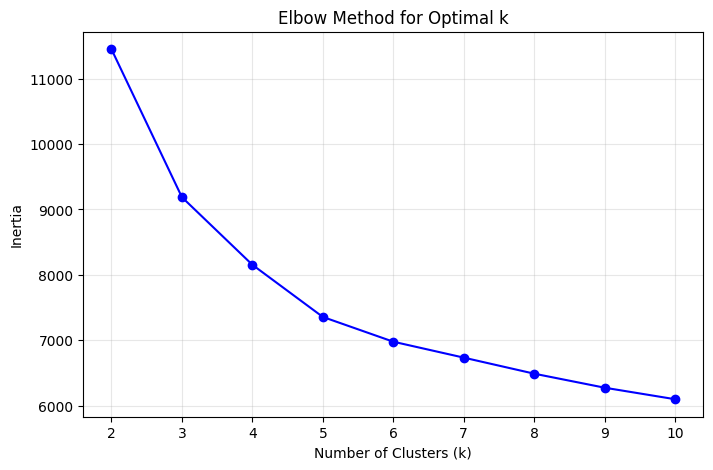

In [111]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_train_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

In [112]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

print("Cluster vs Stroke:")
print(pd.crosstab(clusters, y_train))

Cluster vs Stroke:
stroke     0   1
row_0           
0        855   2
1        371  57
2       1691  90


### PCA Visualization

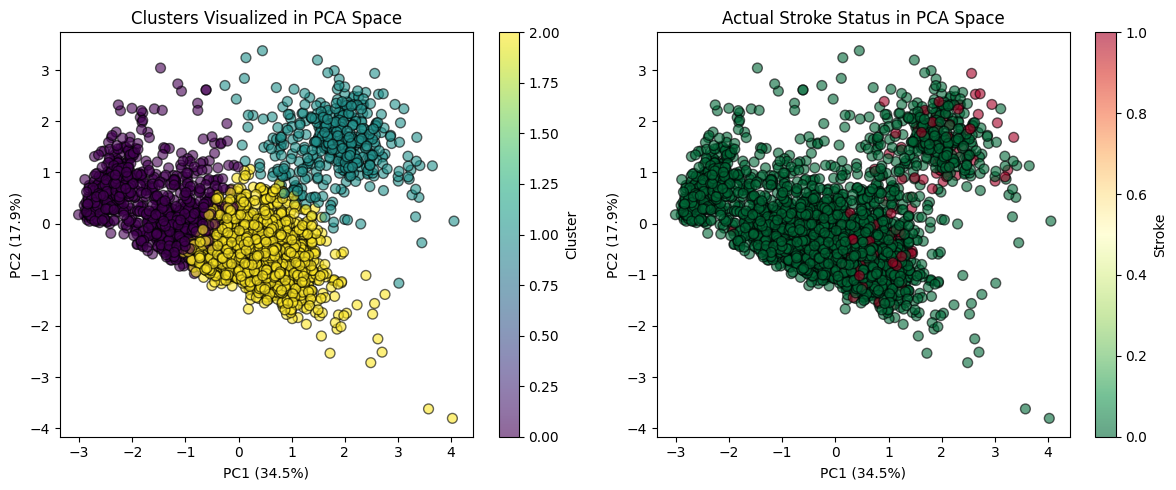

PC1 explains 34.46% of variance
PC2 explains 17.89% of variance
Total: 52.35%


In [113]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolors='k', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Clusters Visualized in PCA Space')
plt.colorbar(scatter, label='Cluster')

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='RdYlGn_r', alpha=0.6, edgecolors='k', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Actual Stroke Status in PCA Space')
plt.colorbar(scatter, label='Stroke')

plt.tight_layout()
plt.show()

print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

In [114]:
cluster_df = X_train_scaled.copy()
cluster_df['cluster'] = clusters
cluster_df['stroke'] = y_train.values

print("Cluster Characteristics (mean values):")
print(cluster_df.groupby('cluster')[numerical_cols].mean())
print("\nStroke rate by cluster:")
print(cluster_df.groupby('cluster')['stroke'].mean() * 100)


Cluster Characteristics (mean values):
              age  avg_glucose_level       bmi
cluster                                       
0       -1.235251          -0.285628 -0.843093
1        0.783759           2.154037  0.552942
2        0.406042          -0.380205  0.272808

Stroke rate by cluster:
cluster
0     0.233372
1    13.317757
2     5.053341
Name: stroke, dtype: float64


### Conlusion

During the unsupervised analysis, K-means identified three main clusters. While cluster one and cluster two had the most cases where there was a stroke (13.30% and 5.05% respectively), the majority of the strokes were still scattered throughout the data. However, cluster zero was extremely safe, containing only two cases where there was a stroke. Overall, the structure is moderate and the clusters do not separate strokes very well, suggesting missing relationships. Because of this, we will add feature additions and/or transformations in the supervised section of this notebook.

# Supervised Modeling

### Logistic Regression

In [115]:
warnings.filterwarnings('ignore')

# Testing different regularization strengths
# Smaller C = more regularization (simpler model), larger C = less regularization (more complex)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

results_lr = []

#### Baseline: Untransformed Data

**Rationale**: Establish a baseline using original scaled features without transformations. This allows us to see if feature engineering improves results.


In [116]:

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_scaled, y_train)
    
    train_pred = lr.predict(X_train_scaled)
    val_pred = lr.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Baseline',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    overfit_gap = train_acc - val_acc
    if overfit_gap > 0.05:
        reason = " (Overfitting - large train/val gap)"
    elif train_acc < 0.7 and val_acc < 0.7:
        reason = " (Underfitting - both low)"
    else:
        reason = ""
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}{reason}")

baseline_results = [r for r in results_lr if r['transformation'] == 'Baseline']
best_baseline = max(baseline_results, key=lambda x: x['val_f1'])
print(f"\nBest baseline: C={best_baseline['C']} with F1={best_baseline['val_f1']:.4f}")
gap = best_baseline['train_acc'] - best_baseline['val_acc']
if gap > 0.05:
    print(f"  - Overfitting (train {gap:.3f} higher than val) - will try stronger regularization")
elif best_baseline['train_acc'] < 0.75:
    print("  - Underfitting - will try adding features to capture more patterns")


C= 0.001: Train Acc=0.7179, Val Acc=0.7290, Val Prec=0.1350, Val Rec=0.8400, Val F1=0.2327
C= 0.010: Train Acc=0.7283, Val Acc=0.7329, Val Prec=0.1344, Val Rec=0.8200, Val F1=0.2310
C= 0.100: Train Acc=0.7397, Val Acc=0.7476, Val Prec=0.1414, Val Rec=0.8200, Val F1=0.2412
C= 1.000: Train Acc=0.7417, Val Acc=0.7573, Val Prec=0.1464, Val Rec=0.8200, Val F1=0.2485
C=10.000: Train Acc=0.7410, Val Acc=0.7593, Val Prec=0.1475, Val Rec=0.8200, Val F1=0.2500
C=100.000: Train Acc=0.7404, Val Acc=0.7593, Val Prec=0.1475, Val Rec=0.8200, Val F1=0.2500

Best baseline: C=10 with F1=0.2500
  - Underfitting - will try adding features to capture more patterns


#### Transformation 1: Polynomial Features (Degree 2)

**Why**: Clusters didn't separate stroke well, so maybe we need non-linear relationships. Polynomial features create combinations like age² and age×glucose. This adds lots of features, so might need stronger regularization to avoid overfitting.


In [117]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]} ({(X_train_poly.shape[1]/X_train_scaled.shape[1]):.1f}x more)")
print("Expecting lower C values to work better since we have more features now.\n")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_poly, y_train)
    
    train_pred = lr.predict(X_train_poly)
    val_pred = lr.predict(X_val_poly)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Polynomial (deg=2)',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

poly_results = [r for r in results_lr if r['transformation'] == 'Polynomial (deg=2)']
best_poly = max(poly_results, key=lambda x: x['val_f1'])
print(f"\nBest polynomial: C={best_poly['C']} with F1={best_poly['val_f1']:.4f}")
gap = best_poly['train_acc'] - best_poly['val_acc']
if gap > 0.1:
    print(f"  - Bad overfitting (gap={gap:.3f}) - too many features, need stronger regularization")
elif best_poly['val_f1'] > best_baseline['val_f1']:
    print(f"  - Better than baseline! (F1: {best_baseline['val_f1']:.4f} -> {best_poly['val_f1']:.4f})")
    print("  - Polynomial features are helping")
else:
    print("  - No improvement - polynomial features might just be adding noise")


Original features: 16
Polynomial features: 152 (9.5x more)
Expecting lower C values to work better since we have more features now.

C= 0.001: Train Acc=0.7560, Val Acc=0.7701, Val Prec=0.1509, Val Rec=0.8000, Val F1=0.2540
C= 0.010: Train Acc=0.7538, Val Acc=0.7573, Val Prec=0.1387, Val Rec=0.7600, Val F1=0.2346
C= 0.100: Train Acc=0.7547, Val Acc=0.7564, Val Prec=0.1328, Val Rec=0.7200, Val F1=0.2243
C= 1.000: Train Acc=0.7606, Val Acc=0.7554, Val Prec=0.1269, Val Rec=0.6800, Val F1=0.2138
C=10.000: Train Acc=0.7593, Val Acc=0.7524, Val Prec=0.1227, Val Rec=0.6600, Val F1=0.2069
C=100.000: Train Acc=0.7557, Val Acc=0.7456, Val Prec=0.1140, Val Rec=0.6200, Val F1=0.1925

Best polynomial: C=0.001 with F1=0.2540
  - Better than baseline! (F1: 0.2500 -> 0.2540)
  - Polynomial features are helping


#### Transformation 2: PCA Components

**Why**: PCA reduces features by keeping the important parts (85% of variance). This removes noise and might help if we're overfitting. With fewer features, we might need less regularization.


In [118]:
pca_lr = PCA(n_components=0.85)
X_train_pca = pca_lr.fit_transform(X_train_scaled)
X_val_pca = pca_lr.transform(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]} (removed {X_train_scaled.shape[1] - X_train_pca.shape[1]} features)")
print(f"Kept {sum(pca_lr.explained_variance_ratio_)*100:.1f}% of variance")
print("Fewer features, so might need less regularization.\n")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_pca, y_train)
    
    train_pred = lr.predict(X_train_pca)
    val_pred = lr.predict(X_val_pca)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'PCA (85% var)',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

pca_results = [r for r in results_lr if r['transformation'] == 'PCA (85% var)']
best_pca = max(pca_results, key=lambda x: x['val_f1'])
print(f"\nBest PCA: C={best_pca['C']} with F1={best_pca['val_f1']:.4f}")
gap = best_pca['train_acc'] - best_pca['val_acc']

if best_pca['val_f1'] > best_baseline['val_f1']:
    print(f"  - Better than baseline! (F1: {best_baseline['val_f1']:.4f} -> {best_pca['val_f1']:.4f})")
    if gap < 0.03:
        print("  - Also reduced overfitting - PCA worked well")
else:
    print(f"  - F1 didn't improve (baseline: {best_baseline['val_f1']:.4f})")
    if gap < 0.03:
        print("  - But PCA did reduce overfitting - probably removed signal along with noise")
    else:
        print("  - Didn't help with overfitting either - removed important features")


Original features: 16
PCA components: 7 (removed 9 features)
Kept 88.7% of variance
Fewer features, so might need less regularization.

C= 0.001: Train Acc=0.7100, Val Acc=0.7182, Val Prec=0.1281, Val Rec=0.8200, Val F1=0.2216
C= 0.010: Train Acc=0.7162, Val Acc=0.7309, Val Prec=0.1359, Val Rec=0.8400, Val F1=0.2340
C= 0.100: Train Acc=0.7221, Val Acc=0.7348, Val Prec=0.1353, Val Rec=0.8200, Val F1=0.2323
C= 1.000: Train Acc=0.7241, Val Acc=0.7348, Val Prec=0.1353, Val Rec=0.8200, Val F1=0.2323
C=10.000: Train Acc=0.7244, Val Acc=0.7358, Val Prec=0.1358, Val Rec=0.8200, Val F1=0.2330
C=100.000: Train Acc=0.7244, Val Acc=0.7358, Val Prec=0.1358, Val Rec=0.8200, Val F1=0.2330

Best PCA: C=0.01 with F1=0.2340
  - F1 didn't improve (baseline: 0.2500)
  - But PCA did reduce overfitting - probably removed signal along with noise


#### Transformation 3: Interaction Terms

**Why**: Medical knowledge says some combinations matter, like age×glucose or hypertension×heart_disease. Adding just these specific interactions instead of all polynomial terms. More targeted than polynomial features.


In [119]:
print("Only 5 new features (vs 100+ from polynomial).\n")

X_train_interact = X_train_scaled.copy()
X_val_interact = X_val_scaled.copy()

X_train_interact['age_glucose'] = X_train_scaled['age'] * X_train_scaled['avg_glucose_level']
X_train_interact['age_bmi'] = X_train_scaled['age'] * X_train_scaled['bmi']
X_train_interact['glucose_bmi'] = X_train_scaled['avg_glucose_level'] * X_train_scaled['bmi']
X_train_interact['hypertension_heart'] = X_train_scaled['hypertension'] * X_train_scaled['heart_disease']
X_train_interact['age_hypertension'] = X_train_scaled['age'] * X_train_scaled['hypertension']

X_val_interact['age_glucose'] = X_val_scaled['age'] * X_val_scaled['avg_glucose_level']
X_val_interact['age_bmi'] = X_val_scaled['age'] * X_val_scaled['bmi']
X_val_interact['glucose_bmi'] = X_val_scaled['avg_glucose_level'] * X_val_scaled['bmi']
X_val_interact['hypertension_heart'] = X_val_scaled['hypertension'] * X_val_scaled['heart_disease']
X_val_interact['age_hypertension'] = X_val_scaled['age'] * X_val_scaled['hypertension']

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"With interactions: {X_train_interact.shape[1]} (+5 features)")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_interact, y_train)
    
    train_pred = lr.predict(X_train_interact)
    val_pred = lr.predict(X_val_interact)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Interactions',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

interact_results = [r for r in results_lr if r['transformation'] == 'Interactions']
best_interact = max(interact_results, key=lambda x: x['val_f1'])
print(f"\nBest interactions: C={best_interact['C']} with F1={best_interact['val_f1']:.4f}")
gap = best_interact['train_acc'] - best_interact['val_acc']
if gap > 0.05:
    print(f"  - Some overfitting (gap={gap:.3f}) - might need stronger regularization")
elif best_interact['val_f1'] > best_baseline['val_f1']:
    print(f"  - Better than baseline! (F1: {best_baseline['val_f1']:.4f} -> {best_interact['val_f1']:.4f})")
    print("  - These interactions are helping")
else:
    print("  - No improvement - interactions might not matter as much")

Only 5 new features (vs 100+ from polynomial).

Original features: 16
With interactions: 21 (+5 features)
C= 0.001: Train Acc=0.7427, Val Acc=0.7544, Val Prec=0.1423, Val Rec=0.8000, Val F1=0.2417
C= 0.010: Train Acc=0.7378, Val Acc=0.7397, Val Prec=0.1376, Val Rec=0.8200, Val F1=0.2356
C= 0.100: Train Acc=0.7391, Val Acc=0.7466, Val Prec=0.1409, Val Rec=0.8200, Val F1=0.2405
C= 1.000: Train Acc=0.7414, Val Acc=0.7476, Val Prec=0.1389, Val Rec=0.8000, Val F1=0.2367
C=10.000: Train Acc=0.7427, Val Acc=0.7495, Val Prec=0.1424, Val Rec=0.8200, Val F1=0.2426
C=100.000: Train Acc=0.7427, Val Acc=0.7495, Val Prec=0.1424, Val Rec=0.8200, Val F1=0.2426

Best interactions: C=10 with F1=0.2426
  - No improvement - interactions might not matter as much


#### Results Summary Table


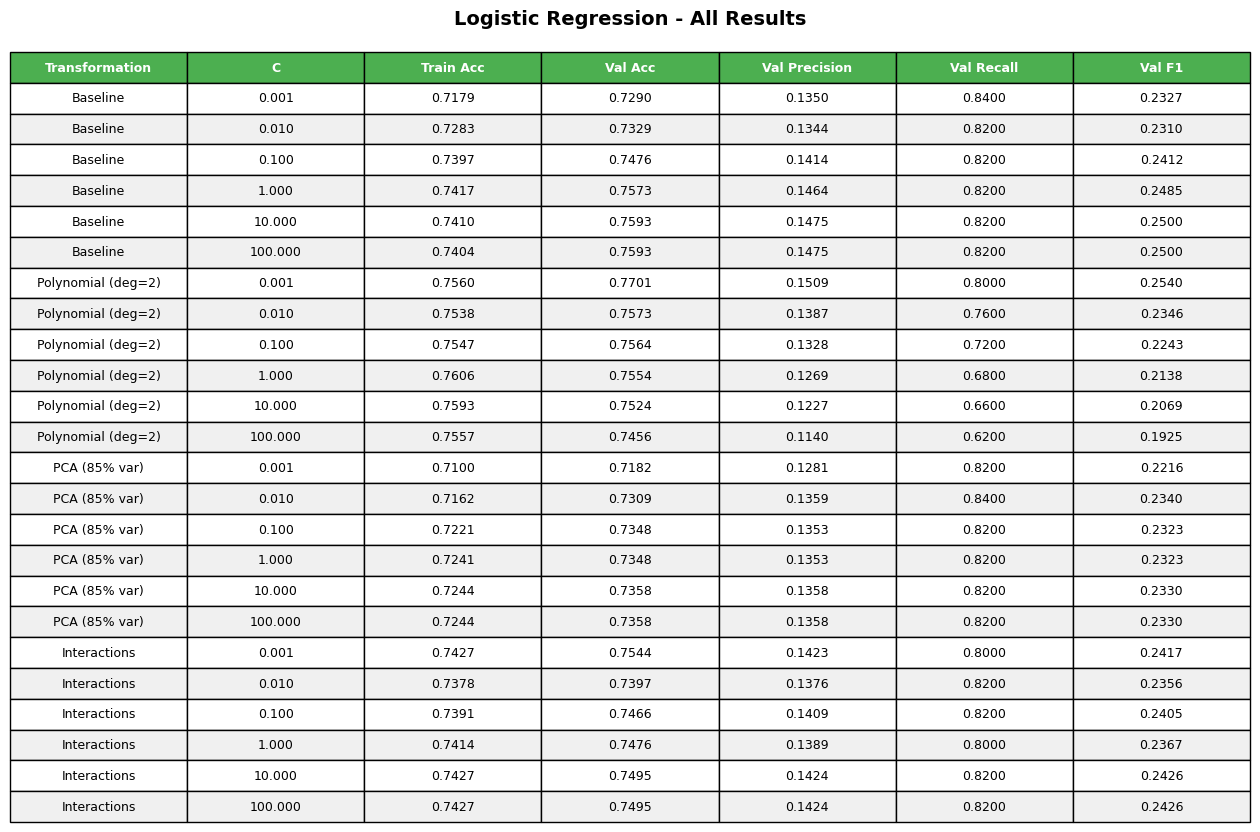


Best Model: Polynomial (deg=2) with C=0.001
  Train Acc: 0.7560, Val Acc: 0.7701
  Val Precision: 0.1509, Val Recall: 0.8000, Val F1: 0.2540


In [120]:
lr_results_df = pd.DataFrame(results_lr)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in lr_results_df.iterrows():
    table_data.append([
        row['transformation'],
        f"{row['C']:.3f}",
        f"{row['train_acc']:.4f}",
        f"{row['val_acc']:.4f}",
        f"{row['val_precision']:.4f}",
        f"{row['val_recall']:.4f}",
        f"{row['val_f1']:.4f}"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Transformation', 'C', 'Train Acc', 'Val Acc', 'Val Precision', 'Val Recall', 'Val F1'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(len(table_data) + 1):
    for j in range(7):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        elif i % 2 == 0:
            cell.set_facecolor('#f0f0f0')
        else:
            cell.set_facecolor('white')

plt.title('Logistic Regression - All Results', fontsize=14, fontweight='bold', pad=20)
plt.show()

best_overall = lr_results_df.loc[lr_results_df['val_f1'].idxmax()]
print(f"\nBest Model: {best_overall['transformation']} with C={best_overall['C']:.3f}")
print(f"  Train Acc: {best_overall['train_acc']:.4f}, Val Acc: {best_overall['val_acc']:.4f}")
print(f"  Val Precision: {best_overall['val_precision']:.4f}, Val Recall: {best_overall['val_recall']:.4f}, Val F1: {best_overall['val_f1']:.4f}")

lr_best_model = best_overall
lr_all_metrics = lr_results_df


### Superviesed Method 2 (NN, KNN, CNN, etc)

In [121]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

#k_values = [1, 2, 3, 5, 7, 11, 15]
k_values = range(1, 21)

cov_matrix = np.cov(X_train_scaled.T)     # transpose to get correct orientation
inv_cov_matrix = np.linalg.inv(cov_matrix)

knn_m = KNeighborsClassifier(
    n_neighbors=k,
    metric='mahalanobis',
    metric_params={'VI': inv_cov_matrix}
)

def run_knn(X_train, y_train, X_val, y_val, k_values, weighted=0):
    results = []
    for k in k_values:
        if weighted==1:
            knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        elif weighted == 0:
            knn = KNeighborsClassifier(n_neighbors=k)
        else:
            knn= knn_m
        knn.fit(X_train, y_train)
        y_pred_train = knn.predict(X_train)
        y_pred_val = knn.predict(X_val)
        y_probs_val = knn.predict_proba(X_val)[:, 1]
        acc_train = accuracy_score(y_train, y_pred_train)
        acc_val = accuracy_score(y_val, y_pred_val)
        precision_val = precision_score(y_val, y_pred_val, zero_division = 0)
        recall_val = recall_score(y_val, y_pred_val, zero_division=0)
        f1_val = f1_score(y_val, y_pred_val, zero_division=0)
        val_auc = roc_auc_score(y_val, y_probs_val)
            

        results.append({
            "k": k,
            "Training Accuracy": acc_train,
            "Validation Accuracy": acc_val,
            "Precision": precision_val,
            "Recall": recall_val,
            "F1": f1_val,
            "AUC": val_auc
        })
            
        overfit_gap = acc_train - acc_val
        if overfit_gap > 0.05:
            reason = " (Overfitting — boundary too sharp)"
        elif acc_train < 0.7 and acc_val < 0.7:
            reason = " (Underfitting — decision boundary too smooth)"
        else:
            reason = ""
        print(
            f"k={k:2d}: "
            f"Train Acc={acc_train:.4f},  Val Acc={acc_val:.4f},  "
            f"Prec={precision_val:.4f},  Rec={recall_val:.4f},  "
            f"F1={f1_val:.4f},  AUC={val_auc:.4f}{reason}"
        )
    return pd.DataFrame(results)


def choose_best_k(results_df):
    best_idx = results_df["F1"].idxmax()
    best_row = results_df.loc[best_idx]
    print("\n=== BEST KNN MODEL ===")
    print(
        f"Selected k = {best_row['k']} "
        f"with F1={best_row['F1']:.4f} "
        f"and AUC={best_row['AUC']:.4f}"
    )
    gap = best_row["Training Accuracy"] - best_row["Validation Accuracy"]

    if gap > 0.05:
        print("→ Overfitting detected — will consider larger k or feature transformations.")
    elif best_row["Training Accuracy"] < 0.75:
        print("→ Underfitting — will explore more complex feature transformations (Z-space).")
    else:
        print("→ Balanced — will still test transformations to compare representational power.")
    return best_row
    

Baseline (No Feature Transformations)

In [122]:

k_results_baseline1 = run_knn(X_train_scaled, y_train, X_val_scaled, y_val, k_values, weighted=0 )
best_k_baseline1 = choose_best_k(k_results_baseline1)
k_results_baseline2 = run_knn(X_train_scaled, y_train, X_val_scaled, y_val, k_values, weighted=1 )
best_k_baseline2 = choose_best_k(k_results_baseline2)

k= 1: Train Acc=1.0000,  Val Acc=0.9168,  Prec=0.0930,  Rec=0.0800,  F1=0.0860,  AUC=0.5199 (Overfitting — boundary too sharp)
k= 2: Train Acc=0.9563,  Val Acc=0.9472,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.5751
k= 3: Train Acc=0.9563,  Val Acc=0.9452,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.5976
k= 4: Train Acc=0.9517,  Val Acc=0.9501,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6091
k= 5: Train Acc=0.9511,  Val Acc=0.9501,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6636
k= 6: Train Acc=0.9521,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6647
k= 7: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6705
k= 8: Train Acc=0.9514,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6867
k= 9: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6764
k=10: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6661
k=11: Train Acc=0.9517,  Val Acc=0.9511,  Pre

Polynomial Feature Transformation



In [123]:
# create the transformed data
X_train_poly = X_train_scaled.copy()
X_val_poly = X_val_scaled.copy()
X_test_poly = X_test_scaled.copy()

for df in [X_train_poly, X_val_poly, X_test_poly]:
    df['age_sq'] = df['age'] ** 2
    df['glucose_sq'] = df['avg_glucose_level'] ** 2
    df['bmi_sq'] = df['bmi'] ** 2
    df['age_glucose'] = df['age'] * df['avg_glucose_level']
    df['age_bmi'] = df['age'] * df['bmi']
    df['glucose_bmi'] = df['avg_glucose_level'] * df['bmi']


In [124]:
# run knn w uniform weight
poly_results_uniform = run_knn(X_train_poly, y_train, X_val_poly, y_val, k_values, weighted=0)
best_poly_uniform = choose_best_k(poly_results_uniform)

#run knn w distance weight
poly_results_distance = run_knn(X_train_poly, y_train, X_val_poly, y_val, k_values, weighted=1)
best_poly_distance = choose_best_k(poly_results_distance)


k= 1: Train Acc=1.0000,  Val Acc=0.9119,  Prec=0.1429,  Rec=0.1600,  F1=0.1509,  AUC=0.5553 (Overfitting — boundary too sharp)
k= 2: Train Acc=0.9560,  Val Acc=0.9462,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6017
k= 3: Train Acc=0.9569,  Val Acc=0.9432,  Prec=0.1000,  Rec=0.0200,  F1=0.0333,  AUC=0.5982
k= 4: Train Acc=0.9524,  Val Acc=0.9521,  Prec=1.0000,  Rec=0.0200,  F1=0.0392,  AUC=0.6199
k= 5: Train Acc=0.9514,  Val Acc=0.9511,  Prec=0.5000,  Rec=0.0200,  F1=0.0385,  AUC=0.6185
k= 6: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6623
k= 7: Train Acc=0.9517,  Val Acc=0.9491,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6788
k= 8: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.7179
k= 9: Train Acc=0.9521,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.7057
k=10: Train Acc=0.9514,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.7084
k=11: Train Acc=0.9514,  Val Acc=0.9511,  Pre


Transformatiom #2: Adding Categorical Interaction Features

In [125]:
print(X_train_scaled.columns.tolist())

['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'gender_Male', 'gender_Other', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


In [126]:
def add_interactions(df):
    df = df.copy()
    df['female'] = 1 - df['gender_Male'] - df.get('gender_Other', 0)
    df = df.drop(columns=[col for col in ['gender_Male', 'gender_Other'] if col in df.columns])

    df['female_former_smoker'] = df['female'] * df['smoking_status_formerly smoked']
    df['female_current_smoker'] = df['female'] * df['smoking_status_smokes']
    df['married_urban'] = df['ever_married'] * df['Residence_type']
    df['married_female'] = df['ever_married'] * df['female']

    df['age_hypertension'] = df['age'] * df['hypertension']
    df['age_heart_disease'] = df['age'] * df['heart_disease']

    return df


In [127]:
X_train_inter = add_interactions(X_train_scaled)
X_val_inter = add_interactions(X_val_scaled)
X_test_inter = add_interactions(X_test_scaled)

X_train_inter[['female_former_smoker','female_current_smoker','married_urban',
               'married_female','age_hypertension','age_heart_disease']].head()



,female_former_smoker,female_current_smoker,married_urban,married_female,age_hypertension,age_heart_disease
1990,0,0,0,0,-0.0,-0.0
3840,1,0,0,0,-0.0,-0.0
2596,0,0,0,1,0.0,0.0
591,0,0,1,0,0.0,0.0
2975,0,0,0,1,-0.0,-0.0


In [128]:
results_inter_uniform = run_knn(
    X_train_inter, y_train,
    X_val_inter, y_val,
    k_values,
    weighted=0
)
best_inter_uniform = choose_best_k(results_inter_uniform)

# Distance weight
results_inter_distance = run_knn(
    X_train_inter, y_train,
    X_val_inter, y_val,
    k_values,
    weighted=1
)
best_inter_distance = choose_best_k(results_inter_distance)

k= 1: Train Acc=1.0000,  Val Acc=0.9159,  Prec=0.1087,  Rec=0.1000,  F1=0.1042,  AUC=0.5289 (Overfitting — boundary too sharp)
k= 2: Train Acc=0.9563,  Val Acc=0.9491,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.5748
k= 3: Train Acc=0.9556,  Val Acc=0.9481,  Prec=0.2000,  Rec=0.0200,  F1=0.0364,  AUC=0.5870
k= 4: Train Acc=0.9534,  Val Acc=0.9491,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6047
k= 5: Train Acc=0.9530,  Val Acc=0.9491,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6335
k= 6: Train Acc=0.9511,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6380
k= 7: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6483
k= 8: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6707
k= 9: Train Acc=0.9521,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6869
k=10: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6963
k=11: Train Acc=0.9517,  Val Acc=0.9511,  Pre

Transformation 3: Binning


In [129]:
import numpy as np
import pandas as pd

def add_quantile_bins(X_train, X_val, X_test):
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()

    # Quantile bin edges based ONLY on training set
    age_bins = np.quantile(X_train['age'], [0, .25, .5, .75, 1])
    glucose_bins = np.quantile(X_train['avg_glucose_level'], [0, .25, .5, .75, 1])
    
    # Digitize criteria (this produces 0,1,2,3 categories)
    X_train['age_bin'] = np.digitize(X_train['age'], age_bins[1:-1], right=True)
    X_val['age_bin'] = np.digitize(X_val['age'], age_bins[1:-1], right=True)
    X_test['age_bin'] = np.digitize(X_test['age'], age_bins[1:-1], right=True)

    X_train['glucose_bin'] = np.digitize(X_train['avg_glucose_level'], glucose_bins[1:-1], right=True)
    X_val['glucose_bin'] = np.digitize(X_val['avg_glucose_level'], glucose_bins[1:-1], right=True)
    X_test['glucose_bin'] = np.digitize(X_test['avg_glucose_level'], glucose_bins[1:-1], right=True)

    return X_train, X_val, X_test, age_bins, glucose_bins


In [130]:


X_train_quant, X_val_quant, X_test_quant, age_bins, glucose_bins = add_quantile_bins(
    X_train_scaled, X_val_scaled, X_test_scaled
)
results_quant_uniform = run_knn(
    X_train_quant, y_train,
    X_val_quant, y_val,
    k_values,
    weighted=0
)
best_quant_uniform = choose_best_k(results_quant_uniform)

results_quant_distance = run_knn(
    X_train_quant, y_train,
    X_val_quant, y_val,
    k_values,
    weighted=1
)
best_quant_distance = choose_best_k(results_quant_distance)

k= 1: Train Acc=1.0000,  Val Acc=0.9159,  Prec=0.1400,  Rec=0.1400,  F1=0.1400,  AUC=0.5479 (Overfitting — boundary too sharp)
k= 2: Train Acc=0.9560,  Val Acc=0.9511,  Prec=0.5000,  Rec=0.0200,  F1=0.0385,  AUC=0.5460
k= 3: Train Acc=0.9569,  Val Acc=0.9472,  Prec=0.1667,  Rec=0.0200,  F1=0.0357,  AUC=0.5525
k= 4: Train Acc=0.9524,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.5516
k= 5: Train Acc=0.9514,  Val Acc=0.9491,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6182
k= 6: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6421
k= 7: Train Acc=0.9504,  Val Acc=0.9491,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6414
k= 8: Train Acc=0.9514,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6713
k= 9: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6830
k=10: Train Acc=0.9517,  Val Acc=0.9511,  Prec=0.0000,  Rec=0.0000,  F1=0.0000,  AUC=0.6786
k=11: Train Acc=0.9511,  Val Acc=0.9511,  Pre

KNN Results Table 

KNN - COMPLETE RESULTS TABLE (Best k for each configuration)

Transformation            Weighting    k      Train Acc    Val Acc      Val Prec     Val Recall   Val F1       Val AUC     
------------------------------------------------------------------------------------------------------------------------
Polynomial                Uniform      1      1.0000       0.9119       0.1429       0.1600       0.1509       0.5553      
Polynomial                Distance     1      1.0000       0.9119       0.1429       0.1600       0.1509       0.5553      
Quantile Binning          Uniform      1      1.0000       0.9159       0.1400       0.1400       0.1400       0.5479      
Quantile Binning          Distance     1      1.0000       0.9159       0.1400       0.1400       0.1400       0.5479      
Categorical Interactions  Uniform      1      1.0000       0.9159       0.1087       0.1000       0.1042       0.5289      
Categorical Interactions  Distance     1      1.0000       0.9159       0

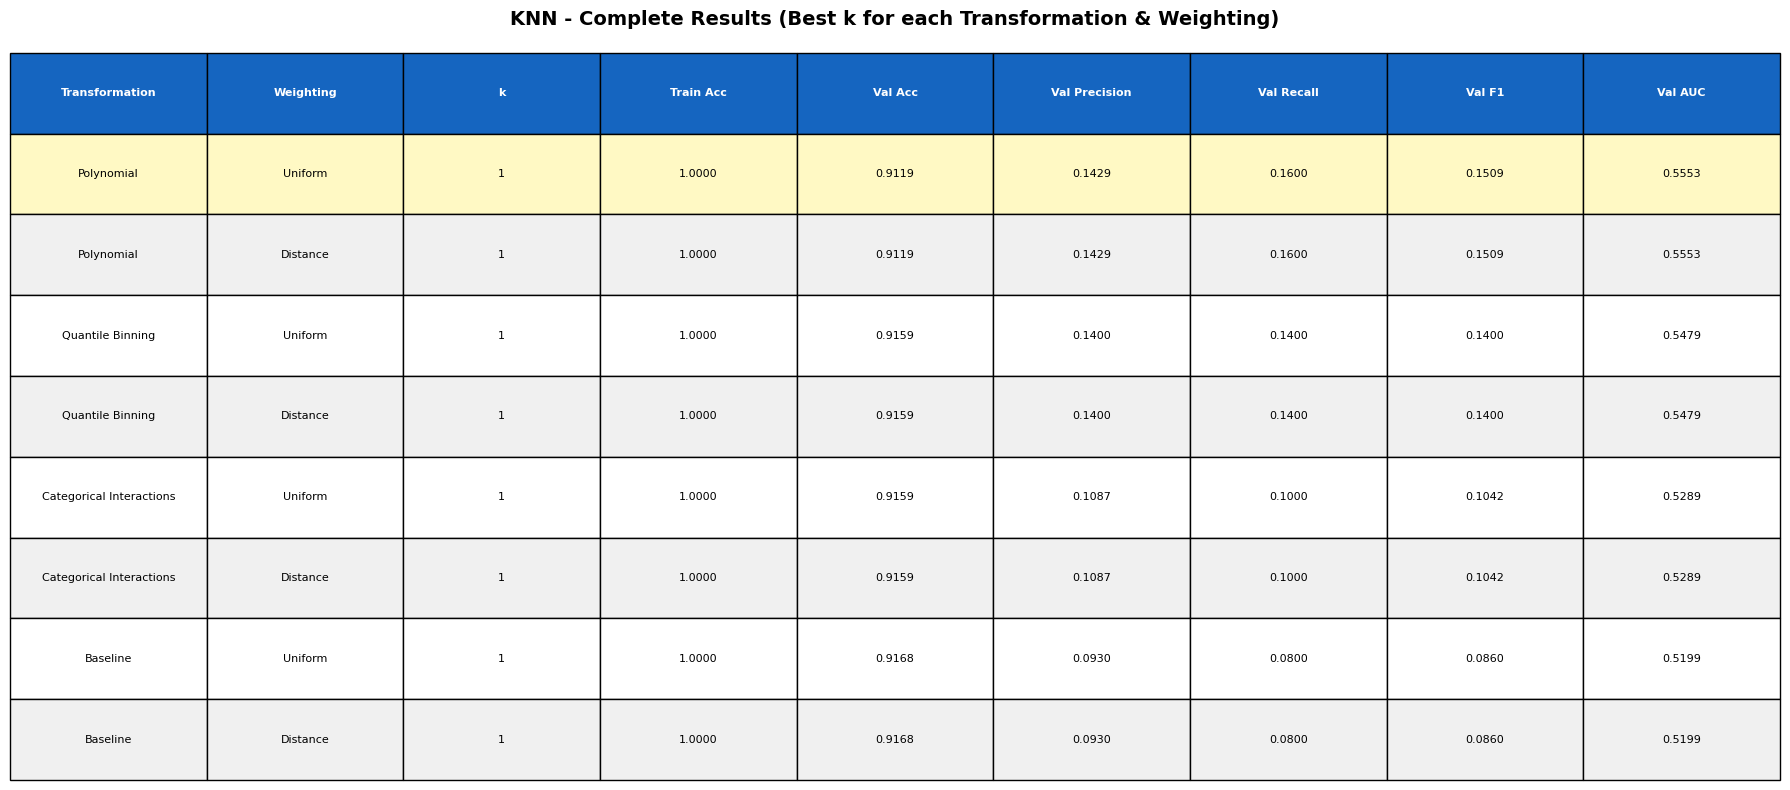


BEST KNN MODEL:
  Transformation: Polynomial
  Weighting: Uniform
  k: 1
  Train Acc: 1.0000
  Val Acc: 0.9119
  Val Precision: 0.1429
  Val Recall: 0.1600
  Val F1: 0.1509
  Val AUC: 0.5553


In [131]:
# Compile all KNN results
knn_all_results = []

# Baseline
knn_all_results.append({
    'Transformation': 'Baseline',
    'Weighting': 'Uniform',
    'k': best_k_baseline1['k'],
    'Train Acc': best_k_baseline1['Training Accuracy'],
    'Val Acc': best_k_baseline1['Validation Accuracy'],
    'Val Precision': best_k_baseline1['Precision'],
    'Val Recall': best_k_baseline1['Recall'],
    'Val F1': best_k_baseline1['F1'],
    'Val AUC': best_k_baseline1['AUC']
})
knn_all_results.append({
    'Transformation': 'Baseline',
    'Weighting': 'Distance',
    'k': best_k_baseline2['k'],
    'Train Acc': best_k_baseline2['Training Accuracy'],
    'Val Acc': best_k_baseline2['Validation Accuracy'],
    'Val Precision': best_k_baseline2['Precision'],
    'Val Recall': best_k_baseline2['Recall'],
    'Val F1': best_k_baseline2['F1'],
    'Val AUC': best_k_baseline2['AUC']
})

knn_all_results.append({
    'Transformation': 'Polynomial',
    'Weighting': 'Uniform',
    'k': best_poly_uniform['k'],
    'Train Acc': best_poly_uniform['Training Accuracy'],
    'Val Acc': best_poly_uniform['Validation Accuracy'],
    'Val Precision': best_poly_uniform['Precision'],
    'Val Recall': best_poly_uniform['Recall'],
    'Val F1': best_poly_uniform['F1'],
    'Val AUC': best_poly_uniform['AUC']
})
knn_all_results.append({
    'Transformation': 'Polynomial',
    'Weighting': 'Distance',
    'k': best_poly_distance['k'],
    'Train Acc': best_poly_distance['Training Accuracy'],
    'Val Acc': best_poly_distance['Validation Accuracy'],
    'Val Precision': best_poly_distance['Precision'],
    'Val Recall': best_poly_distance['Recall'],
    'Val F1': best_poly_distance['F1'],
    'Val AUC': best_poly_distance['AUC']
})

knn_all_results.append({
    'Transformation': 'Categorical Interactions',
    'Weighting': 'Uniform',
    'k': best_inter_uniform['k'],
    'Train Acc': best_inter_uniform['Training Accuracy'],
    'Val Acc': best_inter_uniform['Validation Accuracy'],
    'Val Precision': best_inter_uniform['Precision'],
    'Val Recall': best_inter_uniform['Recall'],
    'Val F1': best_inter_uniform['F1'],
    'Val AUC': best_inter_uniform['AUC']
})
knn_all_results.append({
    'Transformation': 'Categorical Interactions',
    'Weighting': 'Distance',
    'k': best_inter_distance['k'],
    'Train Acc': best_inter_distance['Training Accuracy'],
    'Val Acc': best_inter_distance['Validation Accuracy'],
    'Val Precision': best_inter_distance['Precision'],
    'Val Recall': best_inter_distance['Recall'],
    'Val F1': best_inter_distance['F1'],
    'Val AUC': best_inter_distance['AUC']
})

knn_all_results.append({
    'Transformation': 'Quantile Binning',
    'Weighting': 'Uniform',
    'k': best_quant_uniform['k'],
    'Train Acc': best_quant_uniform['Training Accuracy'],
    'Val Acc': best_quant_uniform['Validation Accuracy'],
    'Val Precision': best_quant_uniform['Precision'],
    'Val Recall': best_quant_uniform['Recall'],
    'Val F1': best_quant_uniform['F1'],
    'Val AUC': best_quant_uniform['AUC']
})
knn_all_results.append({
    'Transformation': 'Quantile Binning',
    'Weighting': 'Distance',
    'k': best_quant_distance['k'],
    'Train Acc': best_quant_distance['Training Accuracy'],
    'Val Acc': best_quant_distance['Validation Accuracy'],
    'Val Precision': best_quant_distance['Precision'],
    'Val Recall': best_quant_distance['Recall'],
    'Val F1': best_quant_distance['F1'],
    'Val AUC': best_quant_distance['AUC']
})

knn_results_df = pd.DataFrame(knn_all_results)
knn_results_df = knn_results_df.sort_values('Val F1', ascending=False)

print("=" * 120)
print("KNN - COMPLETE RESULTS TABLE (Best k for each configuration)")
print("=" * 120)
print(f"\n{'Transformation':<25} {'Weighting':<12} {'k':<6} {'Train Acc':<12} {'Val Acc':<12} "
      f"{'Val Prec':<12} {'Val Recall':<12} {'Val F1':<12} {'Val AUC':<12}")
print("-" * 120)

for _, row in knn_results_df.iterrows():
    print(f"{row['Transformation']:<25} {row['Weighting']:<12} {int(row['k']):<6} "
          f"{row['Train Acc']:<12.4f} {row['Val Acc']:<12.4f} {row['Val Precision']:<12.4f} "
          f"{row['Val Recall']:<12.4f} {row['Val F1']:<12.4f} {row['Val AUC']:<12.4f}")

print("=" * 120)

fig, ax = plt.subplots(figsize=(18, 8))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in knn_results_df.iterrows():
    table_data.append([
        row['Transformation'],
        row['Weighting'],
        f"{int(row['k'])}",
        f"{row['Train Acc']:.4f}",
        f"{row['Val Acc']:.4f}",
        f"{row['Val Precision']:.4f}",
        f"{row['Val Recall']:.4f}",
        f"{row['Val F1']:.4f}",
        f"{row['Val AUC']:.4f}"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Transformation', 'Weighting', 'k', 'Train Acc', 'Val Acc',
                          'Val Precision', 'Val Recall', 'Val F1', 'Val AUC'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.8)

for i in range(len(table_data) + 1):
    for j in range(9):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#1565C0')
            cell.set_text_props(weight='bold', color='white')
        elif i % 2 == 0:
            cell.set_facecolor('#f0f0f0')
        else:
            cell.set_facecolor('white')

# Highlight best
best_knn_idx = 1
for j in range(9):
    cell = table[(best_knn_idx, j)]
    cell.set_facecolor('#FFF9C4')

plt.title('KNN - Complete Results (Best k for each Transformation & Weighting)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

best_knn = knn_results_df.iloc[0]
print(f"\n{'='*120}")
print(f"BEST KNN MODEL:")
print(f"  Transformation: {best_knn['Transformation']}")
print(f"  Weighting: {best_knn['Weighting']}")
print(f"  k: {int(best_knn['k'])}")
print(f"  Train Acc: {best_knn['Train Acc']:.4f}")
print(f"  Val Acc: {best_knn['Val Acc']:.4f}")
print(f"  Val Precision: {best_knn['Val Precision']:.4f}")
print(f"  Val Recall: {best_knn['Val Recall']:.4f}")
print(f"  Val F1: {best_knn['Val F1']:.4f}")
print(f"  Val AUC: {best_knn['Val AUC']:.4f}")
print("=" * 120)


### Superviesed Method 3: MLP Neural Network

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print(class_weights_dict)

def run_keras_nn(X_train, y_train, X_val, y_val, alpha_values, transformation_name="Baseline"):
    results = []

    for alpha in alpha_values:
        model = Sequential([
            Dense(32, activation='relu', kernel_regularizer=l2(alpha), input_shape=(X_train.shape[1],)),
            Dense(16, activation='relu', kernel_regularizer=l2(alpha)),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train,
            epochs=30,
            batch_size=32,
            verbose=0,
            class_weight=class_weights_dict
        )

        # Predictions
        y_probs_val = model.predict(X_val).flatten()
        y_pred_val = (y_probs_val > 0.5).astype(int)

        y_probs_train = model.predict(X_train).flatten()
        y_pred_train = (y_probs_train > 0.5).astype(int)

        # Metrics
        train_acc = accuracy_score(y_train, y_pred_train)
        val_acc = accuracy_score(y_val, y_pred_val)
        precision_val = precision_score(y_val, y_pred_val, zero_division=0)
        recall_val = recall_score(y_val, y_pred_val, zero_division=0)
        f1_val = f1_score(y_val, y_pred_val, zero_division=0)
        auc_val = roc_auc_score(y_val, y_probs_val)

        results.append({
            "transformation": transformation_name,
            "alpha": alpha,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "val_precision": precision_val,
            "val_recall": recall_val,
            "val_f1": f1_val,
            "val_auc": auc_val
        })

        print(f"Alpha={alpha:.1e} | "
              f"Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f} | "
              f"P={precision_val:.4f} R={recall_val:.4f} F1={f1_val:.4f} AUC={auc_val:.4f}")

    return pd.DataFrame(results)
def choose_best_keras(results_df):
    best_idx = results_df["val_f1"].idxmax()
    best_row = results_df.loc[best_idx]
    
    print("\n=== BEST KERAS NN MODEL ===")
    print(f"Transformation: {best_row['transformation']}")
    print(f"alpha={best_row['alpha']:.1e} | F1={best_row['val_f1']:.4f} | AUC={best_row['val_auc']:.4f}")
    
    return best_row


"""def run_mlp(X_train, y_train, X_val, y_val, alpha_values, transformation_name="Baseline"):
    results = []

    for alpha in alpha_values:
        mlp = MLPClassifier(
            hidden_layer_sizes=(32, 16),   # 2 hidden layers: 32 and 16 units
            activation='relu',
            solver='adam',
            alpha=alpha,                  # L2 regularization
            max_iter=300,
            random_state=42,
            class_weight="balanced"
        )

        mlp.fit(X_train, y_train)

        # predictions
        y_pred_train = mlp.predict(X_train)
        y_pred_val = mlp.predict(X_val)

        # probs for AUC
        if hasattr(mlp, "predict_proba"):
            y_probs_val = mlp.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, y_probs_val)
        else:
            val_auc = float('nan')

        # metrics
        acc_train = accuracy_score(y_train, y_pred_train)
        acc_val = accuracy_score(y_val, y_pred_val)
        prec_val = precision_score(y_val, y_pred_val, zero_division=0)
        rec_val = recall_score(y_val, y_pred_val, zero_division=0)
        f1_val = f1_score(y_val, y_pred_val, zero_division=0)

        results.append({
            "transformation": transformation_name,
            "alpha": alpha,
            "train_acc": acc_train,
            "val_acc": acc_val,
            "val_precision": prec_val,
            "val_recall": rec_val,
            "val_f1": f1_val,
            "val_auc": val_auc
        })

        overfit_gap = acc_train - acc_val
        if overfit_gap > 0.05:
            reason = " (Overfitting — try stronger regularization)"
        elif acc_train < 0.7 and acc_val < 0.7:
            reason = " (Underfitting — network too simple / too strong reg)"
        else:
            reason = ""
        print(
            f"alpha={alpha:.0e}: "
            f"Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, "
            f"Prec={prec_val:.4f}, Rec={rec_val:.4f}, "
            f"F1={f1_val:.4f}, AUC={val_auc:.4f}{reason}"
        )

    return pd.DataFrame(results)


def choose_best_mlp(results_df):
    best_index = results_df["val_f1"].idxmax()
    best_row = results_df.loc[best_index]
    print("\n=== BEST MLP MODEL ===")
    print(
        f"Transformation: {best_row['transformation']}, "
        f"alpha={best_row['alpha']:.0e}, "
        f"F1={best_row['val_f1']:.4f}, "
        f"AUC={best_row['val_auc']:.4f}"
    )
    gap = best_row["train_acc"] - best_row["val_acc"]
    if gap > 0.05:
        print("→ Overfitting — consider larger alpha or simpler network.")
    elif best_row["train_acc"] < 0.75:
        print("→ Underfitting — may need more capacity or richer features.")
    else:
        print("→ Balanced — good tradeoff between bias and variance.")
    return best_row"""


{np.int64(0): np.float64(0.5255399382927666), np.int64(1): np.float64(10.288590604026846)}


'def run_mlp(X_train, y_train, X_val, y_val, alpha_values, transformation_name="Baseline"):\n    results = []\n\n    for alpha in alpha_values:\n        mlp = MLPClassifier(\n            hidden_layer_sizes=(32, 16),   # 2 hidden layers: 32 and 16 units\n            activation=\'relu\',\n            solver=\'adam\',\n            alpha=alpha,                  # L2 regularization\n            max_iter=300,\n            random_state=42,\n            class_weight="balanced"\n        )\n\n        mlp.fit(X_train, y_train)\n\n        # predictions\n        y_pred_train = mlp.predict(X_train)\n        y_pred_val = mlp.predict(X_val)\n\n        # probs for AUC\n        if hasattr(mlp, "predict_proba"):\n            y_probs_val = mlp.predict_proba(X_val)[:, 1]\n            val_auc = roc_auc_score(y_val, y_probs_val)\n        else:\n            val_auc = float(\'nan\')\n\n        # metrics\n        acc_train = accuracy_score(y_train, y_pred_train)\n        acc_val = accuracy_score(y_val, y_pred_v

No Transformations

In [133]:

alpha_values = [1e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]

keras_baseline_results = run_keras_nn(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    alpha_values,
    transformation_name="Baseline"
)

best_keras_baseline = choose_best_keras(keras_baseline_results)



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
Alpha=1.0e-06 | Train Acc=0.7511 | Val Acc=0.7456 | P=0.1303 R=0.7400 F1=0.2216 AUC=0.8220
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
Alpha=1.0e-05 | Train Acc=0.7430 | Val Acc=0.7417 | P=0.1310 R=0.7600 F1=0.2235 AUC=0.8296
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
Alpha=3.0e-05 | Train Acc=0.7573 | Val Acc=0.7622 | P=0.1439 R=0.7800 F1=0.2430 AUC=0.8255
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step
Alpha=1.0e-04 | Train Acc=0.7743 | Val Acc=0.7652 | P=0.1318 R=0.6800 F1=0.2208 AUC=0.8133
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
Alpha=3.0e-04 | Train Acc=0.7736 | Val Acc=0.7710 | P=0.1434 R=0.7400 F1=0.2403 AUC=0.8175
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
Alpha=1.0e-03 | Train Acc=0.7339 | Val Acc=0.7319 | P=0.1267 R

Transformation 1: Polynomial Feature Transformation

In [134]:
# create the transformed data
X_train_poly = X_train_scaled.copy()
X_val_poly = X_val_scaled.copy()
X_test_poly = X_test_scaled.copy()

for df in [X_train_poly, X_val_poly, X_test_poly]:
    df['age_sq'] = df['age'] ** 2
    df['glucose_sq'] = df['avg_glucose_level'] ** 2
    df['bmi_sq'] = df['bmi'] ** 2
    df['age_glucose'] = df['age'] * df['avg_glucose_level']
    df['age_bmi'] = df['age'] * df['bmi']
    df['glucose_bmi'] = df['avg_glucose_level'] * df['bmi']

In [135]:
keras_baseline_results = run_keras_nn(
    X_train_poly, y_train,
    X_val_poly, y_val,
    alpha_values,
    transformation_name="Polynomial"
)

best_keras_baseline = choose_best_keras(keras_baseline_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
Alpha=1.0e-06 | Train Acc=0.7958 | Val Acc=0.7847 | P=0.1488 R=0.7200 F1=0.2466 AUC=0.8183
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
Alpha=1.0e-05 | Train Acc=0.7975 | Val Acc=0.7838 | P=0.1392 R=0.6600 F1=0.2300 AUC=0.8114
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
Alpha=3.0e-05 | Train Acc=0.7746 | Val Acc=0.7544 | P=0.1292 R=0.7000 F1=0.2181 AUC=0.8068
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
Alpha=1.0e-04 | Train Acc=0.7984 | Val Acc=0.7838 | P=0.1481 R=0.7200 F1=0.2457 AUC=0.8128
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
Alpha=3.0e-04 | Train Acc=0.7567 | Val Acc=0.7485 | P=0.1343 R=0.7600 F1=0.2282 AUC=0.8160
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
Alpha=1.0e-03 | Train Acc=0.7440 | Val Acc=0.7299 | P=0.128

Transformation 2: Log Transform 

In [136]:
def log_transform(df):
    df = df.copy()
    skewed = ["avg_glucose_level", "bmi"]
    for col in skewed:
        df[col + "_log"] = np.log1p(df[col])  # log(1+x) safe for zeros
    return df

X_train_log = log_transform(X_train_scaled)
X_val_log = log_transform(X_val_scaled)
X_test_log = log_transform(X_test_scaled)

In [137]:
nn_log_results = run_keras_nn(
    X_train_poly, y_train,
    X_val_poly, y_val,
    alpha_values,
    transformation_name="Log Transform"
)

best_nn_log = choose_best_keras(nn_log_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
Alpha=1.0e-06 | Train Acc=0.7955 | Val Acc=0.7740 | P=0.1336 R=0.6600 F1=0.2222 AUC=0.8081
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
Alpha=1.0e-05 | Train Acc=0.7583 | Val Acc=0.7427 | P=0.1315 R=0.7600 F1=0.2242 AUC=0.8123
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
Alpha=3.0e-05 | Train Acc=0.7893 | Val Acc=0.7857 | P=0.1435 R=0.6800 F1=0.2369 AUC=0.8205
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
Alpha=1.0e-04 | Train Acc=0.7599 | Val Acc=0.7476 | P=0.1338 R=0.7600 F1=0.2275 AUC=0.8284
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
Alpha=3.0e-04 | Train Acc=0.7635 | Val Acc=0.7622 | P=0.1465 R=0.8000 F1=0.2477 AUC=0.8163
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
Alpha=1.0e-03 | Train Acc=0.7534 | Val Acc=0.7417 | P=0.1361

Power Transform 

In [138]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

continuous = ["age", "avg_glucose_level", "bmi"]  

pt.fit(X_train_scaled[continuous])

def power_transform(df):
    df = df.copy()
    df[continuous] = pt.transform(df[continuous])
    return df

X_train_power = power_transform(X_train_scaled)
X_val_power = power_transform(X_val_scaled)
X_test_power = power_transform(X_test_scaled)


In [139]:
keras_power_results = run_keras_nn(
    X_train_power, y_train,
    X_val_power, y_val,
    alpha_values,
    transformation_name="Power"
)
best_power = choose_best_keras(keras_power_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
Alpha=1.0e-06 | Train Acc=0.7459 | Val Acc=0.7564 | P=0.1382 R=0.7600 F1=0.2338 AUC=0.8120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
Alpha=1.0e-05 | Train Acc=0.7423 | Val Acc=0.7378 | P=0.1318 R=0.7800 F1=0.2254 AUC=0.8229
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
Alpha=3.0e-05 | Train Acc=0.7339 | Val Acc=0.7241 | P=0.1159 R=0.7000 F1=0.1989 AUC=0.8122
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
Alpha=1.0e-04 | Train Acc=0.7436 | Val Acc=0.7485 | P=0.1343 R=0.7600 F1=0.2282 AUC=0.8083
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
Alpha=3.0e-04 | Train Acc=0.7684 | Val Acc=0.7593 | P=0.1343 R=0.7200 F1=0.2264 AUC=0.8210
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
Alpha=1.0e-03 | Train Acc=0.7697 | Val Acc=0.7740 | P=0.142

NEURAL NETWORK (KERAS) - COMPLETE RESULTS TABLE

Transformation            Alpha (λ)       Train Acc    Val Acc      Val Prec     Val Recall   Val F1       Val AUC     
------------------------------------------------------------------------------------------------------------------------
Log Transform             1.00e-06        0.7955       0.7740       0.1336       0.6600       0.2222       0.8081      
Log Transform             1.00e-05        0.7583       0.7427       0.1315       0.7600       0.2242       0.8123      
Log Transform             3.00e-05        0.7893       0.7857       0.1435       0.6800       0.2369       0.8205      
Log Transform             1.00e-04        0.7599       0.7476       0.1338       0.7600       0.2275       0.8284      
Log Transform             3.00e-04        0.7635       0.7622       0.1465       0.8000       0.2477       0.8163      
Log Transform             1.00e-03        0.7534       0.7417       0.1361       0.8000       0.2326       0.8

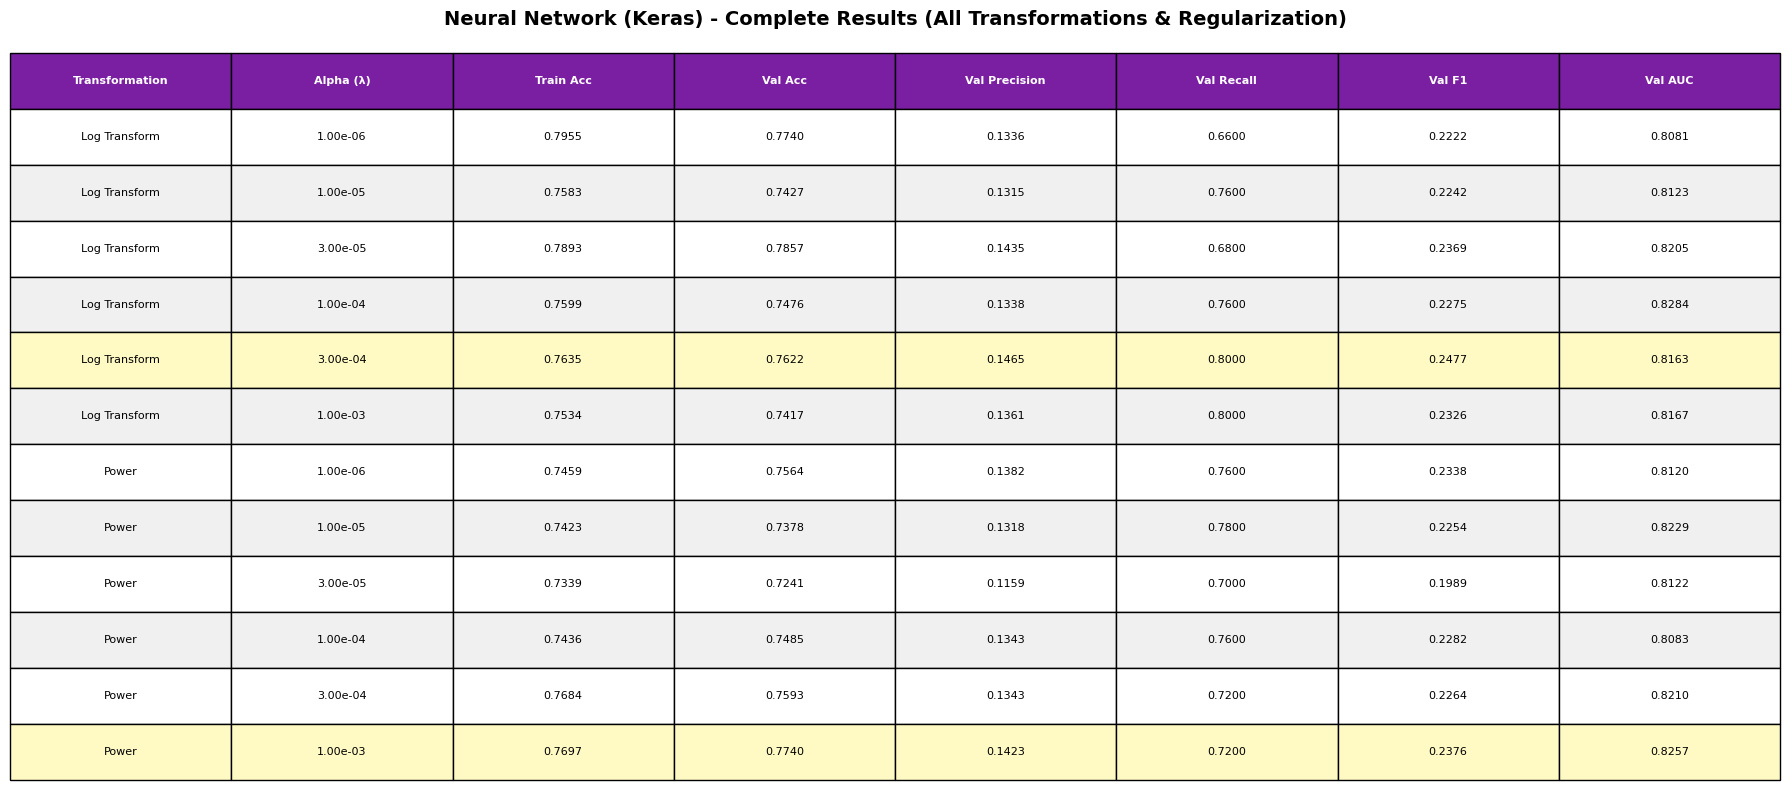


BEST NEURAL NETWORK MODEL:
  Transformation: Log Transform
  Alpha (λ): 3.00e-04
  Train Acc: 0.7635
  Val Acc: 0.7622
  Val Precision: 0.1465
  Val Recall: 0.8000
  Val F1: 0.2477
  Val AUC: 0.8163


In [140]:

nn_all_results = []

if 'keras_baseline_results' in globals():
    for _, row in keras_baseline_results.iterrows():
        if row['transformation'] == 'Baseline':
            nn_all_results.append({
                'Transformation': 'Baseline',
                'Alpha': row['alpha'],
                'Train Acc': row['train_acc'],
                'Val Acc': row['val_acc'],
                'Val Precision': row['val_precision'],
                'Val Recall': row['val_recall'],
                'Val F1': row['val_f1'],
                'Val AUC': row['val_auc']
            })

# Re-run to get all transformations properly
print("Collecting Neural Network results...")

# Baseline (from cell 63)
if 'keras_baseline_results' in globals():
    baseline_nn = keras_baseline_results[keras_baseline_results['transformation'] == 'Baseline'].copy()
    for _, row in baseline_nn.iterrows():
        nn_all_results.append({
            'Transformation': 'Baseline',
            'Alpha': row['alpha'],
            'Train Acc': row['train_acc'],
            'Val Acc': row['val_acc'],
            'Val Precision': row['val_precision'],
            'Val Recall': row['val_recall'],
            'Val F1': row['val_f1'],
            'Val AUC': row['val_auc']
        })


if 'nn_log_results' in globals():
    for _, row in nn_log_results.iterrows():
        nn_all_results.append({
            'Transformation': row['transformation'],
            'Alpha': row['alpha'],
            'Train Acc': row['train_acc'],
            'Val Acc': row['val_acc'],
            'Val Precision': row['val_precision'],
            'Val Recall': row['val_recall'],
            'Val F1': row['val_f1'],
            'Val AUC': row['val_auc']
        })

# Power Transform (from cell 72)
if 'keras_power_results' in globals():
    for _, row in keras_power_results.iterrows():
        nn_all_results.append({
            'Transformation': row['transformation'],
            'Alpha': row['alpha'],
            'Train Acc': row['train_acc'],
            'Val Acc': row['val_acc'],
            'Val Precision': row['val_precision'],
            'Val Recall': row['val_recall'],
            'Val F1': row['val_f1'],
            'Val AUC': row['val_auc']
        })

if nn_all_results:
    nn_results_df = pd.DataFrame(nn_all_results)
    nn_results_df = nn_results_df.sort_values(['Transformation', 'Alpha'])
    
    print("=" * 120)
    print("NEURAL NETWORK (KERAS) - COMPLETE RESULTS TABLE")
    print("=" * 120)
    print(f"\n{'Transformation':<25} {'Alpha (λ)':<15} {'Train Acc':<12} {'Val Acc':<12} "
          f"{'Val Prec':<12} {'Val Recall':<12} {'Val F1':<12} {'Val AUC':<12}")
    print("-" * 120)
    
    for _, row in nn_results_df.iterrows():
        print(f"{row['Transformation']:<25} {row['Alpha']:<15.2e} {row['Train Acc']:<12.4f} "
              f"{row['Val Acc']:<12.4f} {row['Val Precision']:<12.4f} {row['Val Recall']:<12.4f} "
              f"{row['Val F1']:<12.4f} {row['Val AUC']:<12.4f}")
    
    print("=" * 120)
    
    # Visual table
    fig, ax = plt.subplots(figsize=(18, max(8, len(nn_results_df) * 0.3)))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    for _, row in nn_results_df.iterrows():
        table_data.append([
            row['Transformation'],
            f"{row['Alpha']:.2e}",
            f"{row['Train Acc']:.4f}",
            f"{row['Val Acc']:.4f}",
            f"{row['Val Precision']:.4f}",
            f"{row['Val Recall']:.4f}",
            f"{row['Val F1']:.4f}",
            f"{row['Val AUC']:.4f}"
        ])
    
    table = ax.table(cellText=table_data,
                    colLabels=['Transformation', 'Alpha (λ)', 'Train Acc', 'Val Acc',
                              'Val Precision', 'Val Recall', 'Val F1', 'Val AUC'],
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    
    for i in range(len(table_data) + 1):
        for j in range(8):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#7B1FA2')
                cell.set_text_props(weight='bold', color='white')
            elif i % 2 == 0:
                cell.set_facecolor('#f0f0f0')
            else:
                cell.set_facecolor('white')
    
    # Highlight best F1 for each transformation
    transformations = nn_results_df['Transformation'].unique()
    for trans in transformations:
        trans_rows = nn_results_df[nn_results_df['Transformation'] == trans]
        best_idx = trans_rows['Val F1'].idxmax()
        row_idx = nn_results_df.index.get_loc(best_idx) + 1
        for j in range(8):
            cell = table[(row_idx, j)]
            cell.set_facecolor('#FFF9C4')
    
    plt.title('Neural Network (Keras) - Complete Results (All Transformations & Regularization)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    best_nn = nn_results_df.loc[nn_results_df['Val F1'].idxmax()]
    print(f"\n{'='*120}")
    print(f"BEST NEURAL NETWORK MODEL:")
    print(f"  Transformation: {best_nn['Transformation']}")
    print(f"  Alpha (λ): {best_nn['Alpha']:.2e}")
    print(f"  Train Acc: {best_nn['Train Acc']:.4f}")
    print(f"  Val Acc: {best_nn['Val Acc']:.4f}")
    print(f"  Val Precision: {best_nn['Val Precision']:.4f}")
    print(f"  Val Recall: {best_nn['Val Recall']:.4f}")
    print(f"  Val F1: {best_nn['Val F1']:.4f}")
    print(f"  Val AUC: {best_nn['Val AUC']:.4f}")
    print("=" * 120)
else:
    print("Neural Network results not found. Please run the NN cells first.")


# Results

### 2. KNN - Complete Results Table


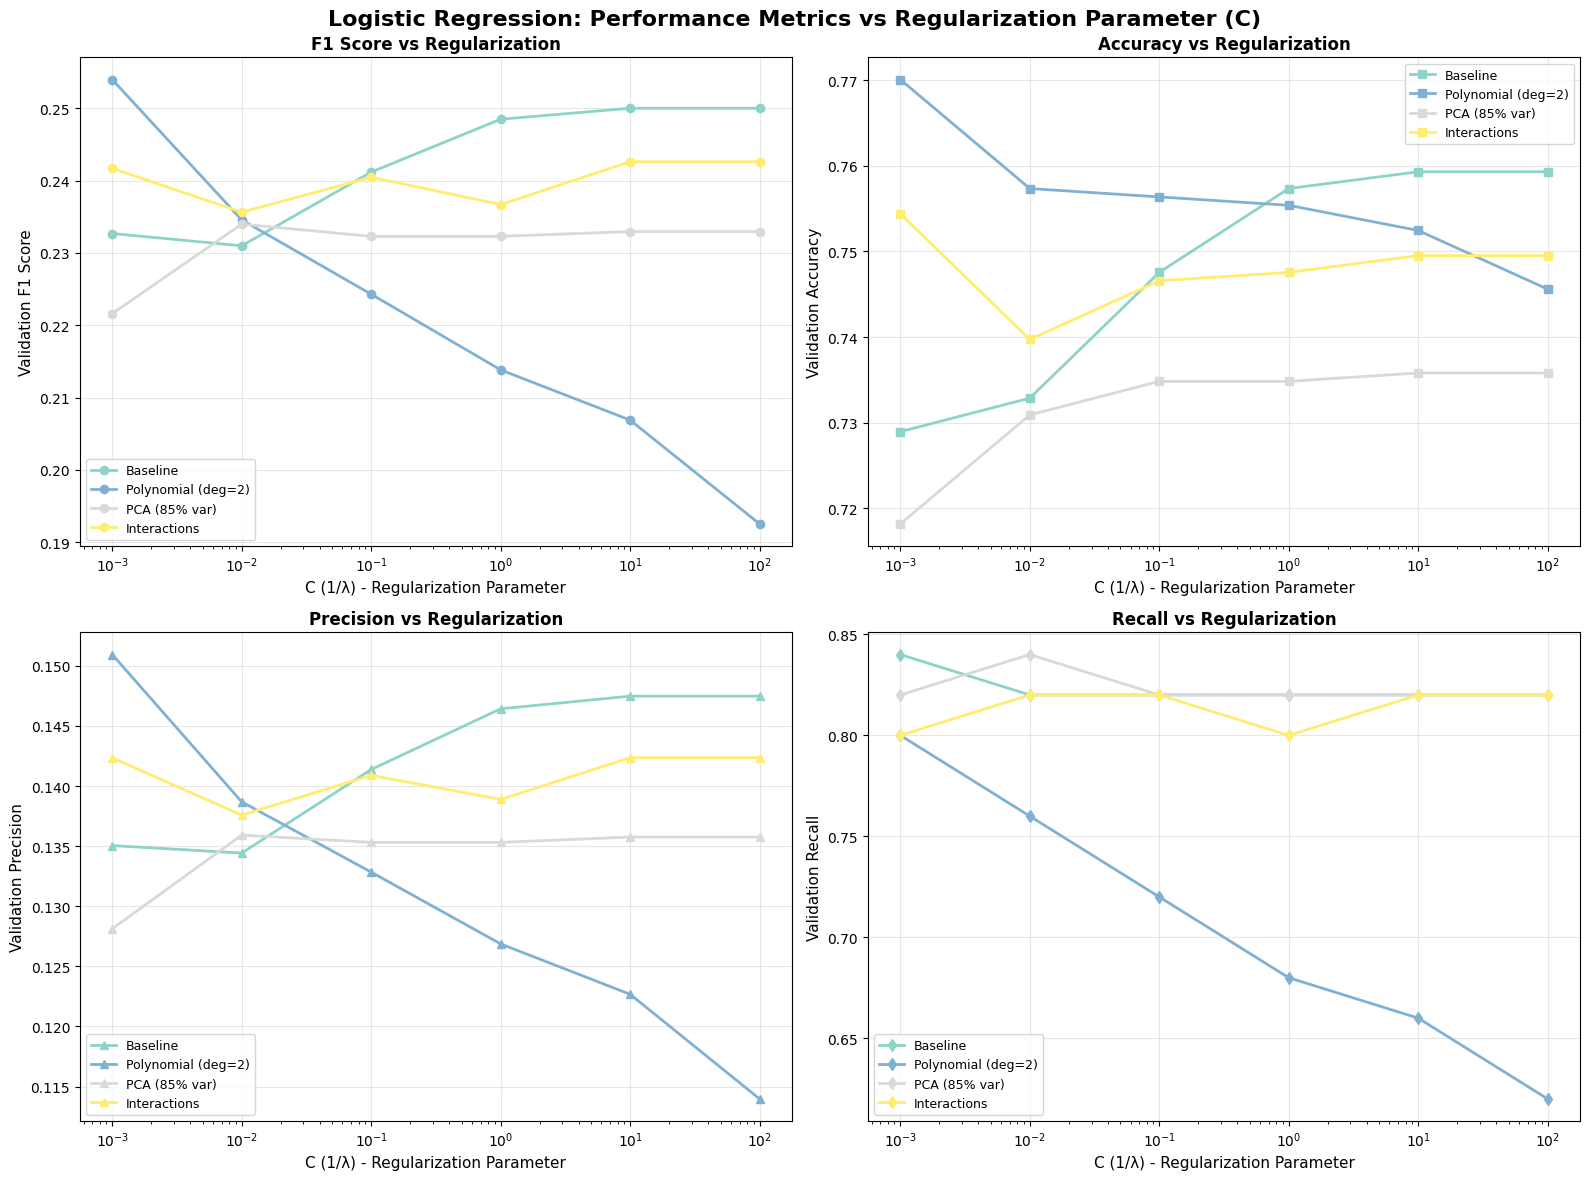

In [142]:
# Plot 1: Logistic Regression - F1 Score vs Regularization (C)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Logistic Regression: Performance Metrics vs Regularization Parameter (C)', 
             fontsize=16, fontweight='bold')

transformations_lr = lr_results_df['transformation'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(transformations_lr)))
color_map = dict(zip(transformations_lr, colors))

# F1 Score
ax = axes[0, 0]
for trans in transformations_lr:
    trans_data = lr_results_df[lr_results_df['transformation'] == trans].sort_values('C')
    ax.plot(trans_data['C'], trans_data['val_f1'], marker='o', label=trans, 
            color=color_map[trans], linewidth=2, markersize=6)
ax.set_xscale('log')
ax.set_xlabel('C (1/λ) - Regularization Parameter', fontsize=11)
ax.set_ylabel('Validation F1 Score', fontsize=11)
ax.set_title('F1 Score vs Regularization', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# Accuracy
ax = axes[0, 1]
for trans in transformations_lr:
    trans_data = lr_results_df[lr_results_df['transformation'] == trans].sort_values('C')
    ax.plot(trans_data['C'], trans_data['val_acc'], marker='s', label=trans, 
            color=color_map[trans], linewidth=2, markersize=6)
ax.set_xscale('log')
ax.set_xlabel('C (1/λ) - Regularization Parameter', fontsize=11)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.set_title('Accuracy vs Regularization', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# Precision
ax = axes[1, 0]
for trans in transformations_lr:
    trans_data = lr_results_df[lr_results_df['transformation'] == trans].sort_values('C')
    ax.plot(trans_data['C'], trans_data['val_precision'], marker='^', label=trans, 
            color=color_map[trans], linewidth=2, markersize=6)
ax.set_xscale('log')
ax.set_xlabel('C (1/λ) - Regularization Parameter', fontsize=11)
ax.set_ylabel('Validation Precision', fontsize=11)
ax.set_title('Precision vs Regularization', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# Recall
ax = axes[1, 1]
for trans in transformations_lr:
    trans_data = lr_results_df[lr_results_df['transformation'] == trans].sort_values('C')
    ax.plot(trans_data['C'], trans_data['val_recall'], marker='d', label=trans, 
            color=color_map[trans], linewidth=2, markersize=6)
ax.set_xscale('log')
ax.set_xlabel('C (1/λ) - Regularization Parameter', fontsize=11)
ax.set_ylabel('Validation Recall', fontsize=11)
ax.set_title('Recall vs Regularization', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


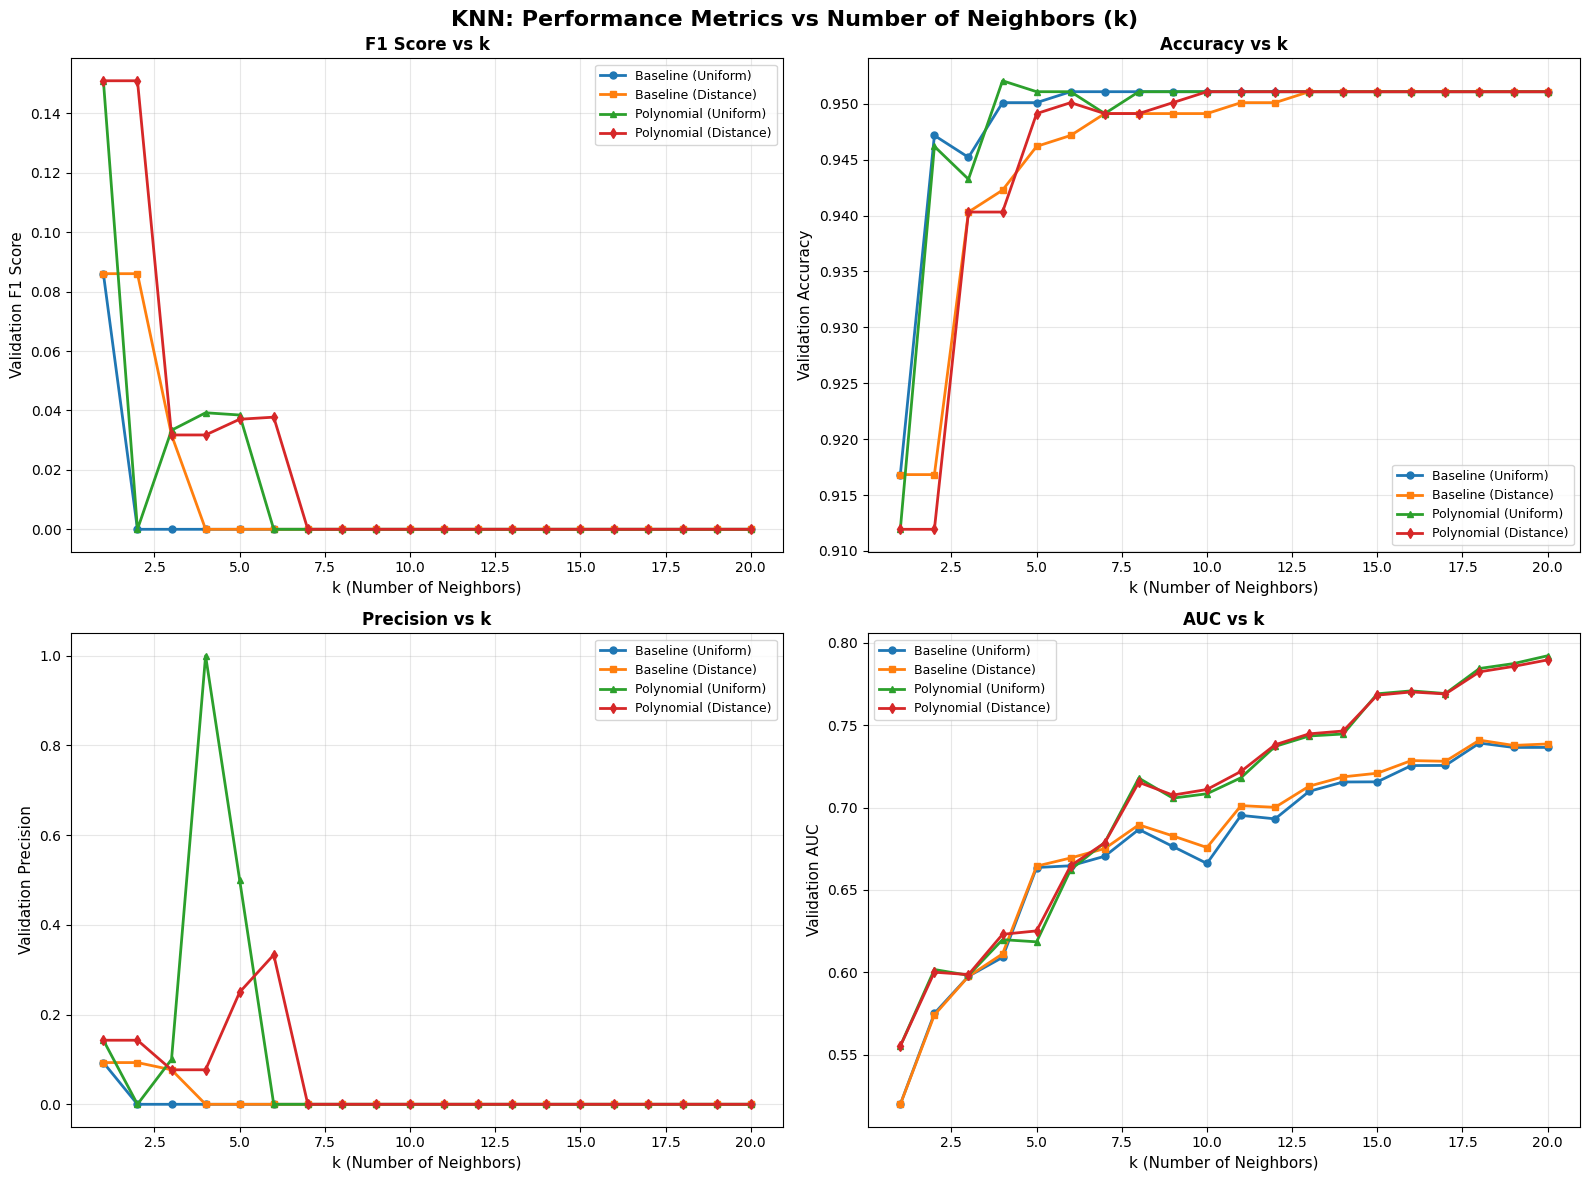

In [143]:
# Plot 2: KNN - Performance vs k (neighbors)
# Collect all k values for each transformation
knn_detailed_results = []

# Baseline uniform
for _, row in k_results_baseline1.iterrows():
    knn_detailed_results.append({
        'Transformation': 'Baseline',
        'Weighting': 'Uniform',
        'k': row['k'],
        'Val F1': row['F1'],
        'Val Acc': row['Validation Accuracy'],
        'Val Precision': row['Precision'],
        'Val Recall': row['Recall'],
        'Val AUC': row['AUC']
    })

# Baseline distance
for _, row in k_results_baseline2.iterrows():
    knn_detailed_results.append({
        'Transformation': 'Baseline',
        'Weighting': 'Distance',
        'k': row['k'],
        'Val F1': row['F1'],
        'Val Acc': row['Validation Accuracy'],
        'Val Precision': row['Precision'],
        'Val Recall': row['Recall'],
        'Val AUC': row['AUC']
    })

# Polynomial uniform
for _, row in poly_results_uniform.iterrows():
    knn_detailed_results.append({
        'Transformation': 'Polynomial',
        'Weighting': 'Uniform',
        'k': row['k'],
        'Val F1': row['F1'],
        'Val Acc': row['Validation Accuracy'],
        'Val Precision': row['Precision'],
        'Val Recall': row['Recall'],
        'Val AUC': row['AUC']
    })

# Polynomial distance
for _, row in poly_results_distance.iterrows():
    knn_detailed_results.append({
        'Transformation': 'Polynomial',
        'Weighting': 'Distance',
        'k': row['k'],
        'Val F1': row['F1'],
        'Val Acc': row['Validation Accuracy'],
        'Val Precision': row['Precision'],
        'Val Recall': row['Recall'],
        'Val AUC': row['AUC']
    })

knn_detailed_df = pd.DataFrame(knn_detailed_results)

# Plot KNN metrics vs k
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('KNN: Performance Metrics vs Number of Neighbors (k)', 
             fontsize=16, fontweight='bold')

configs = [
    ('Baseline', 'Uniform'),
    ('Baseline', 'Distance'),
    ('Polynomial', 'Uniform'),
    ('Polynomial', 'Distance')
]
colors_knn = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'd']

# F1 Score
ax = axes[0, 0]
for idx, (trans, weight) in enumerate(configs):
    config_data = knn_detailed_df[(knn_detailed_df['Transformation'] == trans) & 
                                   (knn_detailed_df['Weighting'] == weight)].sort_values('k')
    label = f"{trans} ({weight})"
    ax.plot(config_data['k'], config_data['Val F1'], marker=markers[idx], 
            label=label, color=colors_knn[idx], linewidth=2, markersize=5)
ax.set_xlabel('k (Number of Neighbors)', fontsize=11)
ax.set_ylabel('Validation F1 Score', fontsize=11)
ax.set_title('F1 Score vs k', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# Accuracy
ax = axes[0, 1]
for idx, (trans, weight) in enumerate(configs):
    config_data = knn_detailed_df[(knn_detailed_df['Transformation'] == trans) & 
                                   (knn_detailed_df['Weighting'] == weight)].sort_values('k')
    label = f"{trans} ({weight})"
    ax.plot(config_data['k'], config_data['Val Acc'], marker=markers[idx], 
            label=label, color=colors_knn[idx], linewidth=2, markersize=5)
ax.set_xlabel('k (Number of Neighbors)', fontsize=11)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.set_title('Accuracy vs k', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# Precision
ax = axes[1, 0]
for idx, (trans, weight) in enumerate(configs):
    config_data = knn_detailed_df[(knn_detailed_df['Transformation'] == trans) & 
                                   (knn_detailed_df['Weighting'] == weight)].sort_values('k')
    label = f"{trans} ({weight})"
    ax.plot(config_data['k'], config_data['Val Precision'], marker=markers[idx], 
            label=label, color=colors_knn[idx], linewidth=2, markersize=5)
ax.set_xlabel('k (Number of Neighbors)', fontsize=11)
ax.set_ylabel('Validation Precision', fontsize=11)
ax.set_title('Precision vs k', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1, 1]
for idx, (trans, weight) in enumerate(configs):
    config_data = knn_detailed_df[(knn_detailed_df['Transformation'] == trans) & 
                                   (knn_detailed_df['Weighting'] == weight)].sort_values('k')
    label = f"{trans} ({weight})"
    ax.plot(config_data['k'], config_data['Val AUC'], marker=markers[idx], 
            label=label, color=colors_knn[idx], linewidth=2, markersize=5)
ax.set_xlabel('k (Number of Neighbors)', fontsize=11)
ax.set_ylabel('Validation AUC', fontsize=11)
ax.set_title('AUC vs k', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


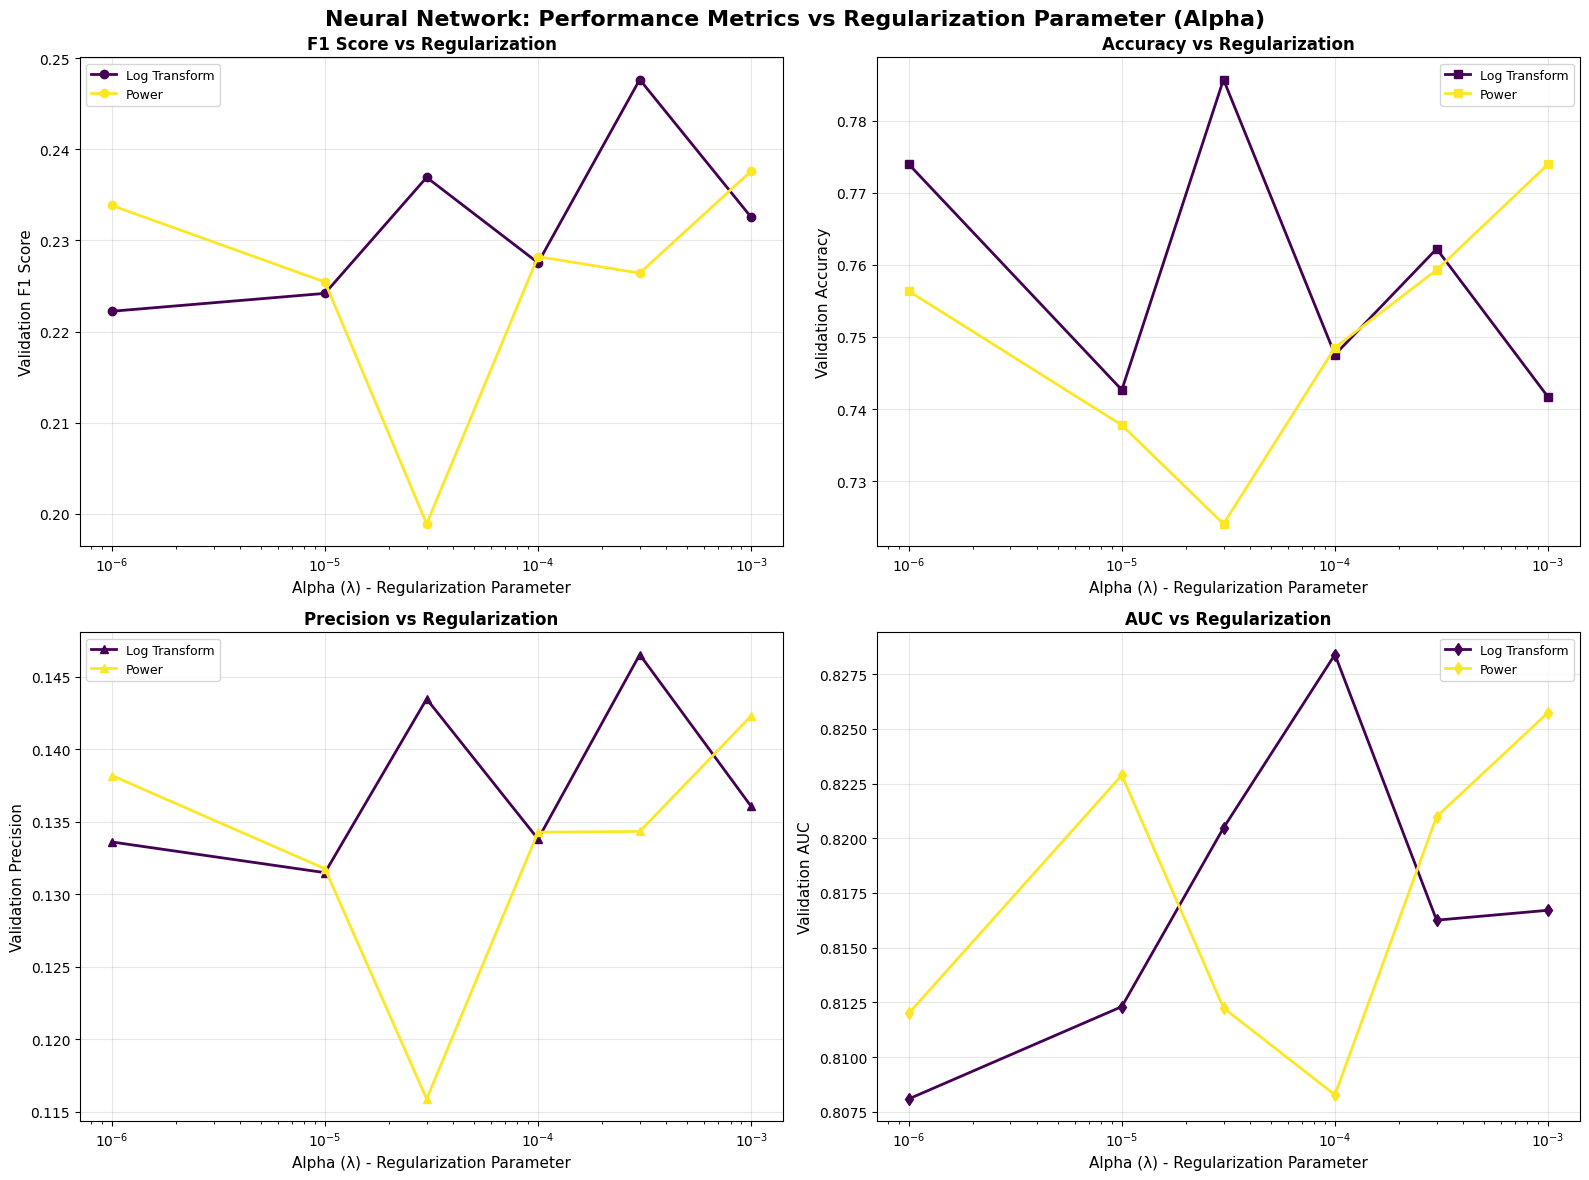

In [144]:
# Plot 3: Neural Network - Performance vs Regularization (Alpha)
if 'nn_results_df' in globals() and len(nn_results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Neural Network: Performance Metrics vs Regularization Parameter (Alpha)', 
                 fontsize=16, fontweight='bold')
    
    transformations_nn = nn_results_df['Transformation'].unique()
    colors_nn = plt.cm.viridis(np.linspace(0, 1, len(transformations_nn)))
    color_map_nn = dict(zip(transformations_nn, colors_nn))
    
    # F1 Score
    ax = axes[0, 0]
    for trans in transformations_nn:
        trans_data = nn_results_df[nn_results_df['Transformation'] == trans].sort_values('Alpha')
        ax.plot(trans_data['Alpha'], trans_data['Val F1'], marker='o', label=trans, 
                color=color_map_nn[trans], linewidth=2, markersize=6)
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (λ) - Regularization Parameter', fontsize=11)
    ax.set_ylabel('Validation F1 Score', fontsize=11)
    ax.set_title('F1 Score vs Regularization', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Accuracy
    ax = axes[0, 1]
    for trans in transformations_nn:
        trans_data = nn_results_df[nn_results_df['Transformation'] == trans].sort_values('Alpha')
        ax.plot(trans_data['Alpha'], trans_data['Val Acc'], marker='s', label=trans, 
                color=color_map_nn[trans], linewidth=2, markersize=6)
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (λ) - Regularization Parameter', fontsize=11)
    ax.set_ylabel('Validation Accuracy', fontsize=11)
    ax.set_title('Accuracy vs Regularization', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Precision
    ax = axes[1, 0]
    for trans in transformations_nn:
        trans_data = nn_results_df[nn_results_df['Transformation'] == trans].sort_values('Alpha')
        ax.plot(trans_data['Alpha'], trans_data['Val Precision'], marker='^', label=trans, 
                color=color_map_nn[trans], linewidth=2, markersize=6)
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (λ) - Regularization Parameter', fontsize=11)
    ax.set_ylabel('Validation Precision', fontsize=11)
    ax.set_title('Precision vs Regularization', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # AUC
    ax = axes[1, 1]
    for trans in transformations_nn:
        trans_data = nn_results_df[nn_results_df['Transformation'] == trans].sort_values('Alpha')
        ax.plot(trans_data['Alpha'], trans_data['Val AUC'], marker='d', label=trans, 
                color=color_map_nn[trans], linewidth=2, markersize=6)
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (λ) - Regularization Parameter', fontsize=11)
    ax.set_ylabel('Validation AUC', fontsize=11)
    ax.set_title('AUC vs Regularization', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Neural Network results not available for plotting.")


### 5. Comparison Across Transformations - Bar Charts


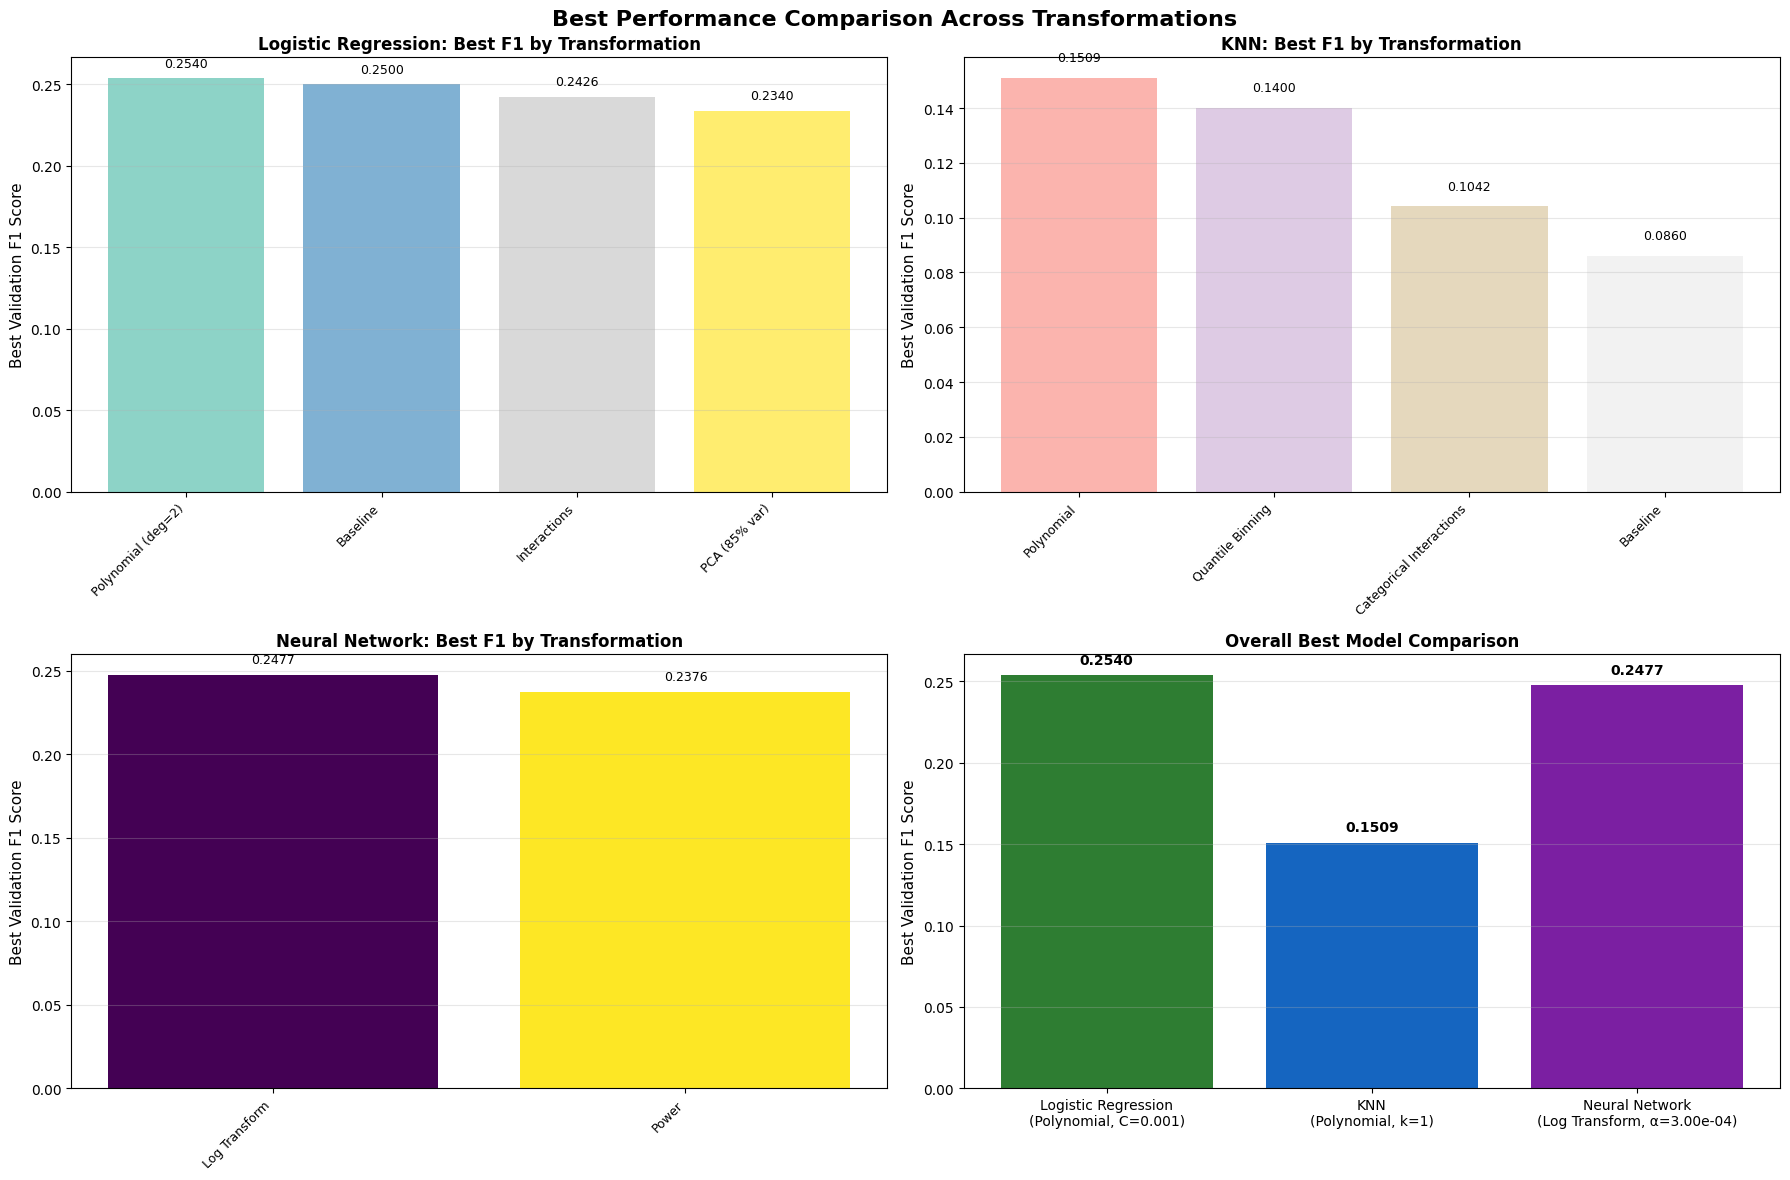

In [145]:
# Compare best performance across transformations for each model
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Best Performance Comparison Across Transformations', 
             fontsize=16, fontweight='bold')

# Logistic Regression - Best F1 for each transformation
ax = axes[0, 0]
lr_best_by_trans = lr_results_df.groupby('transformation')['val_f1'].max().sort_values(ascending=False)
bars = ax.bar(range(len(lr_best_by_trans)), lr_best_by_trans.values, 
              color=plt.cm.Set3(np.linspace(0, 1, len(lr_best_by_trans))))
ax.set_xticks(range(len(lr_best_by_trans)))
ax.set_xticklabels(lr_best_by_trans.index, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Best Validation F1 Score', fontsize=11)
ax.set_title('Logistic Regression: Best F1 by Transformation', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (idx, val) in enumerate(lr_best_by_trans.items()):
    ax.text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# KNN - Best F1 for each transformation
ax = axes[0, 1]
knn_best_by_trans = knn_results_df.groupby('Transformation')['Val F1'].max().sort_values(ascending=False)
bars = ax.bar(range(len(knn_best_by_trans)), knn_best_by_trans.values,
              color=plt.cm.Pastel1(np.linspace(0, 1, len(knn_best_by_trans))))
ax.set_xticks(range(len(knn_best_by_trans)))
ax.set_xticklabels(knn_best_by_trans.index, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Best Validation F1 Score', fontsize=11)
ax.set_title('KNN: Best F1 by Transformation', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (idx, val) in enumerate(knn_best_by_trans.items()):
    ax.text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# Neural Network - Best F1 for each transformation
ax = axes[1, 0]
if 'nn_results_df' in globals() and len(nn_results_df) > 0:
    nn_best_by_trans = nn_results_df.groupby('Transformation')['Val F1'].max().sort_values(ascending=False)
    bars = ax.bar(range(len(nn_best_by_trans)), nn_best_by_trans.values,
                  color=plt.cm.viridis(np.linspace(0, 1, len(nn_best_by_trans))))
    ax.set_xticks(range(len(nn_best_by_trans)))
    ax.set_xticklabels(nn_best_by_trans.index, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Best Validation F1 Score', fontsize=11)
    ax.set_title('Neural Network: Best F1 by Transformation', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for i, (idx, val) in enumerate(nn_best_by_trans.items()):
        ax.text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=9)
else:
    ax.text(0.5, 0.5, 'Neural Network results\nnot available', 
            ha='center', va='center', fontsize=12, transform=ax.transAxes)
    ax.set_title('Neural Network: Best F1 by Transformation', fontsize=12, fontweight='bold')

# Overall Best Model Comparison
ax = axes[1, 1]
models = []
f1_scores = []

# Get best from each model type
best_lr = lr_results_df.loc[lr_results_df['val_f1'].idxmax()]
models.append('Logistic Regression\n(Polynomial, C=0.001)')
f1_scores.append(best_lr['val_f1'])

best_knn = knn_results_df.iloc[0]
models.append(f"KNN\n({best_knn['Transformation']}, k={int(best_knn['k'])})")
f1_scores.append(best_knn['Val F1'])

if 'nn_results_df' in globals() and len(nn_results_df) > 0:
    best_nn = nn_results_df.loc[nn_results_df['Val F1'].idxmax()]
    models.append(f"Neural Network\n({best_nn['Transformation']}, α={best_nn['Alpha']:.2e})")
    f1_scores.append(best_nn['Val F1'])

bars = ax.bar(range(len(models)), f1_scores, 
              color=['#2E7D32', '#1565C0', '#7B1FA2'][:len(models)])
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, fontsize=10)
ax.set_ylabel('Best Validation F1 Score', fontsize=11)
ax.set_title('Overall Best Model Comparison', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, val in enumerate(f1_scores):
    ax.text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### 6. Train vs Validation Performance - Overfitting Analysis


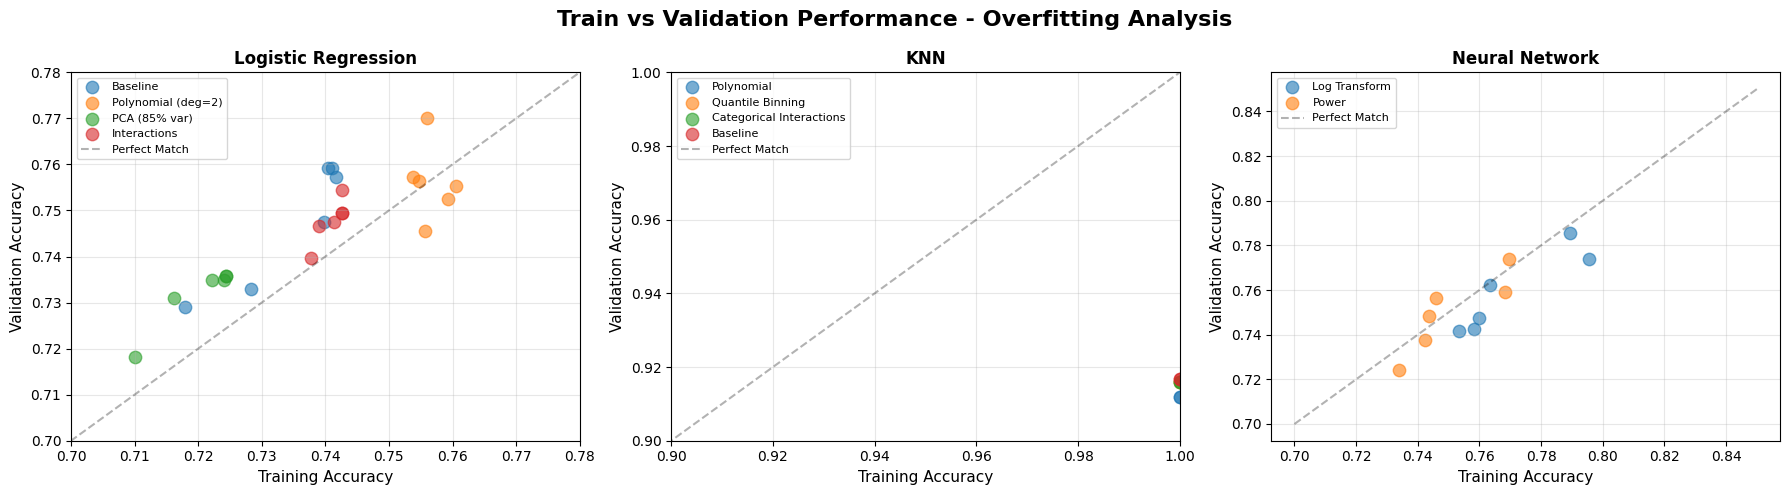

OVERFITTING ANALYSIS - Train vs Validation Gap

Logistic Regression:
  Baseline:
    Mean gap: -0.0127
    Max gap: -0.0046
    Min gap: -0.0189
  Polynomial (deg=2):
    Mean gap: 0.0005
    Max gap: 0.0101
    Min gap: -0.0140
  PCA (85% var):
    Mean gap: -0.0115
    Max gap: -0.0082
    Min gap: -0.0147
  Interactions:
    Mean gap: -0.0068
    Max gap: -0.0020
    Min gap: -0.0117

KNN:
  Polynomial:
    Mean gap: 0.0881
    Max gap: 0.0881
    Min gap: 0.0881
  Quantile Binning:
    Mean gap: 0.0841
    Max gap: 0.0841
    Min gap: 0.0841
  Categorical Interactions:
    Mean gap: 0.0841
    Max gap: 0.0841
    Min gap: 0.0841
  Baseline:
    Mean gap: 0.0832
    Max gap: 0.0832
    Min gap: 0.0832

Neural Network:
  Log Transform:
    Mean gap: 0.0110
    Max gap: 0.0215
    Min gap: 0.0013
  Power:
    Mean gap: 0.0007
    Max gap: 0.0098
    Min gap: -0.0104


In [146]:
# Analyze overfitting patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Train vs Validation Performance - Overfitting Analysis', 
             fontsize=16, fontweight='bold')

# Logistic Regression
ax = axes[0]
for trans in lr_results_df['transformation'].unique():
    trans_data = lr_results_df[lr_results_df['transformation'] == trans]
    ax.scatter(trans_data['train_acc'], trans_data['val_acc'], 
              label=trans, alpha=0.6, s=80)
# Diagonal line (perfect match)
ax.plot([0.6, 1.0], [0.6, 1.0], 'k--', alpha=0.3, label='Perfect Match')
ax.set_xlabel('Training Accuracy', fontsize=11)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.set_title('Logistic Regression', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0.7, 0.78)
ax.set_ylim(0.7, 0.78)

# KNN (using best k for each config)
ax = axes[1]
for trans in knn_results_df['Transformation'].unique():
    trans_data = knn_results_df[knn_results_df['Transformation'] == trans]
    ax.scatter(trans_data['Train Acc'], trans_data['Val Acc'], 
              label=trans, alpha=0.6, s=80)
ax.plot([0.85, 1.0], [0.85, 1.0], 'k--', alpha=0.3, label='Perfect Match')
ax.set_xlabel('Training Accuracy', fontsize=11)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.set_title('KNN', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0.9, 1.0)
ax.set_ylim(0.9, 1.0)

# Neural Network
ax = axes[2]
if 'nn_results_df' in globals() and len(nn_results_df) > 0:
    for trans in nn_results_df['Transformation'].unique():
        trans_data = nn_results_df[nn_results_df['Transformation'] == trans]
        ax.scatter(trans_data['Train Acc'], trans_data['Val Acc'], 
                  label=trans, alpha=0.6, s=80)
    ax.plot([0.7, 0.85], [0.7, 0.85], 'k--', alpha=0.3, label='Perfect Match')
    ax.set_xlabel('Training Accuracy', fontsize=11)
    ax.set_ylabel('Validation Accuracy', fontsize=11)
    ax.set_title('Neural Network', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Neural Network results\nnot available', 
            ha='center', va='center', fontsize=12, transform=ax.transAxes)
    ax.set_title('Neural Network', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate overfitting gaps
print("=" * 120)
print("OVERFITTING ANALYSIS - Train vs Validation Gap")
print("=" * 120)

print("\nLogistic Regression:")
for trans in lr_results_df['transformation'].unique():
    trans_data = lr_results_df[lr_results_df['transformation'] == trans]
    gaps = trans_data['train_acc'] - trans_data['val_acc']
    print(f"  {trans}:")
    print(f"    Mean gap: {gaps.mean():.4f}")
    print(f"    Max gap: {gaps.max():.4f}")
    print(f"    Min gap: {gaps.min():.4f}")

print("\nKNN:")
for trans in knn_results_df['Transformation'].unique():
    trans_data = knn_results_df[knn_results_df['Transformation'] == trans]
    gaps = trans_data['Train Acc'] - trans_data['Val Acc']
    print(f"  {trans}:")
    print(f"    Mean gap: {gaps.mean():.4f}")
    print(f"    Max gap: {gaps.max():.4f}")
    print(f"    Min gap: {gaps.min():.4f}")

if 'nn_results_df' in globals() and len(nn_results_df) > 0:
    print("\nNeural Network:")
    for trans in nn_results_df['Transformation'].unique():
        trans_data = nn_results_df[nn_results_df['Transformation'] == trans]
        gaps = trans_data['Train Acc'] - trans_data['Val Acc']
        print(f"  {trans}:")
        print(f"    Mean gap: {gaps.mean():.4f}")
        print(f"    Max gap: {gaps.max():.4f}")
        print(f"    Min gap: {gaps.min():.4f}")

print("=" * 120)
